# Viscoporoelastic Model Inversion
Rahul Yerrabelli
2021

# Setup

In [ ]:
# First tested on matplotlib-3.2.2
pip install --upgrade matplotlib # want version 3.4

     |████████████████████████████████| 11.2 MB 7.3 MB/s 
     |████████████████████████████████| 884 kB 45.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
#@title ## Basic imports

import sys
print(sys.version)
import time
print(time.ctime())
import IPython.display
import importlib  # for reloading imports to source functions
#from IPython.display import HTML, Math
import os

import itertools
import inspect 
import math
import warnings
import requests

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker
import collections

warnings.simplefilter("default")
#warnings.simplefilter('error'). # throws all warnings as errors
# How to display stack traces, options: Plain, Context (default), Verbose
%xmode Context 
# Turn on or off to cause debug mode to auto enter if exception is thrown
%pdb off

# Below code allows latex to be formatted nicely as google colab output
# Source: https://stackoverflow.com/a/61876185/2879686
def load_mathjax_in_cell_output():
  display(IPython.display.HTML("<script src='https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=default'></script>"))
get_ipython().events.register("pre_run_cell", load_mathjax_in_cell_output)

# Avoids scroll-in-the-scroll in the entire Notebook
def resize_colab_cell():
  display(IPython.display.Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)


"""
requests.get('http://172.28.0.2:9000/api/sessions').json() =
[{'id': 'e0a49454-e812-4d99-aa6f-9d7b80a9616c',
  'kernel': {'connections': 1,
   'execution_state': 'busy',
   'id': '6fd9c8b4-6573-4ffa-a7d6-f56803a0092c',
   'last_activity': '2021-12-01T08:12:08.239708Z',
   'name': 'python3'},
  'name': 'ModelInversions.ipynb',
  'notebook': {'name': 'ModelInversions.ipynb',
   'path': 'fileId=1ZAqQEIxR08eODSPEHvKPwbZoioVdV8L9'},
  'path': 'fileId=1ZAqQEIxR08eODSPEHvKPwbZoioVdV8L9',
  'type': 'notebook'}]
"""
notebook_filename = requests.get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

#@markdown ### `def display_equations(...):`
def display_equations(plot_props):
    # Code created myself (Rahul Yerrabelli)
    for key, val in plot_props.items():
        eqn = val.get("eqn",{}).get("text")
        if eqn:
            # Will display latex. Can be surrounded by $ or not - same result. 
            # However, will not work if there is non-latex text (text not surrounded by $)
            # Thus, remove them all
            display(IPython.display.Math(eqn.replace(r"$",r"$\Huge ", 1).replace(r"$","") ))

simple_laplaces = {}

#@markdown ### `def get_path_to_save(...):`
def get_path_to_save(plot_props:dict=None, file_prefix="", save_filename:str=None, save_in_subfolder:str=None, extension="png", create_folder_if_necessary=True):
    """
    Code created myself (Rahul Yerrabelli)
    """
    replace_characters = {
        "$": "",
        "\\frac":"",
        "\\mathrm":"",
        "\\left(":"(",
        "\\right)":")",
        "\\left[":"[",
        "\\right]":"]",
        "\\": "",
        "/":"-",
        "{": "(",
        "}": ")",
        "<":"",
        ">":"",
        "?":"",
        "_":"",
        "^":"",
        "*":"",
        "!":"",
        ":":"-",
        "|":"-",
        ".":"_",
    }

    # define save_filename based on plot_props
    if plot_props is not None and save_filename is None:
        s_eqn = plot_props["s"]["eqn"]["text"]
        t_eqn = plot_props["t_anal"]["eqn"]["text"]
        simple_laplaces[file_prefix] = {"t":t_eqn,"s":s_eqn}
        if not save_filename:
            save_filename = plot_props["t_anal"]["eqn"]["text"]
        for old, new in replace_characters.items():
            save_filename = save_filename.replace(old,new)
        print(text)

    #save_path = f"../outputs/{notebook_filename.split('.',1)[0]}"
    save_path = ["..","outputs",
                f"{notebook_filename.split('.',1)[0]}",
                ]
    if save_in_subfolder is not None:
        if isinstance(save_in_subfolder, (list, tuple, set, np.ndarray) ):
            save_path.append(**save_in_subfolder)
        else:  # should be a string then
            save_path.append(save_in_subfolder)
    save_path = os.path.join(*save_path)

    if not os.path.exists(save_path) and create_folder_if_necessary:
        os.makedirs(save_path)
    return os.path.join(save_path, file_prefix+save_filename+"."+extension)
    #plt.savefig(os.path.join(save_path, save_filename+"."+extension))

3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Sat Dec 11 12:16:52 2021
Exception reporting mode: Context
Automatic pdb calling has been turned OFF


In [2]:
#@title ## Mount google drive and import my code

try:
    from google.colab import drive
    # Need to move out of google drive directory if going to remount
    %cd
    # drive.mount documentation can be accessed via: drive.mount?
    #Signature: drive.mount(mountpoint, force_remount=False, timeout_ms=120000, use_metadata_server=False)
    mountpoint_folder_name = "gdrive"  # can be anything, doesn't have to be drive
    drive.mount(os.path.join("/content/",mountpoint_folder_name), force_remount=True)  # mounts to a folder called mountpoint_folder_name
    new_path = os.path.join("/content/",mountpoint_folder_name,
                            "MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src")
    if new_path not in sys.path:
        pass
        #sys.path.insert(0,new_path)
    %cd "/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src"
    #%cd "/content/gdrive"
    
except ModuleNotFoundError:  # in case not run in Google colab
    import traceback
    traceback.print_exc()


#from src.inverting import euler_inversion
#from src import plotting
#from src import viscoporoelastic_model
#from src.viscoporoelastic_model import ViscoporoelasticModel
#from inverting import euler_inversion
import inverting
import plotting
import viscoporoelastic_model
from viscoporoelastic_model import CohenModel


<IPython.core.display.Javascript object>

/root
Mounted at /content/gdrive
/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src


/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
#@title ## Specific imports for bessel functions

# Numpy besseli (i0) function doesn't support complex values and only has order 0
def I0(x):      return sp.special.iv(0, x) #return np.i0(x); #besseli(0, x)
def I1(x):      return sp.special.iv(1, x) #besseli(1, x)
def Iv(x,v):    return sp.special.iv(v, x)
def J0(x):      return sp.special.jv(0, x)
def J1(x):      return sp.special.jv(1, x)
def Jv(x,v):    return sp.special.jv(v, x)
def ln(x):      return np.log(x)  #import math #return math.log(x)


<IPython.core.display.Javascript object>


## Define Latex function operators
$
\renewcommand{\Re}{\operatorname{Re}}
\renewcommand{\Im}{\operatorname{Im}}
$  
* $\Im{z}$ and $\Re{z}$ operators of complex numbers   

The default Im and Re are hard to read and it is cumbersum to do `\operatorname{Re}` or `\mathrm{Re}` every time.


$$
\newcommand{\laplace}[2][]{\mathscr{L}^{#1}\left\{ #2\right\}}
\newcommand{\L}[1]{\laplace{#1}}
\newcommand{\ilaplace}[1]{\laplace[-1]{#1}}
$$
* Laplace, $\L{s}$ and $\ilaplace{t}$ using `\mathscr{L}` 

Alternative option is `\mathcal{L}`



## Helper math / model equations

In [7]:
#@title  `def getCohenModelModified(...):`

def getCohenModelModified(**kwargs):
    class CohenModelModified2(CohenModel):
        t0_tg = kwargs.get("t0_tg",10/40.62) or 10/40.62;   # unitless
        tg  = kwargs.get("tg",40.62) or 40.62               # sec
        strain_rate = kwargs.get("strain_rate",0.01) or 0.01;   # per sec
        E1  = kwargs.get("E1", 8.5)  or 8.5                 # kPa
        E3  = kwargs.get("E3", 19)   or 19                  # kPa
        v21 = kwargs.get("v21",0.75) or 0.75                # like Vrtheta
        v31 = kwargs.get("v31",0.24) or 0.24                # like Vrz
    return CohenModelModified2()

<IPython.core.display.Javascript object>

In [6]:
#@title `def` functions for approximating derivatives
def get_midpoint(vals):
    return (vals[1:]+vals[0:-1])/2
def get_diff2(vals, step):  # 2nd order differentiation approximation, returns array of size n-2
    return (vals[2:]-2*vals[1:-1]+vals[0:-2])/step**2
def get_nth_gradient(vals, step, n=1):
    # step can be a value or an array (anything that np.gradient takes)
    if n==1:
        return np.gradient(vals, step)
    elif n>1:  # recursion
        return np.gradient( get_nth_gradient(vals,step,n-1), step )


<IPython.core.display.Javascript object>

# Key Points from Prior Paper
Yuan, D., Somers, S.M., Grayson, W.L. et al. A Poroelastic Model of a Fibrous-Porous Tissue Engineering Scaffold. Sci Rep 8, 5043 (2018). https://doi.org/10.1038/s41598-018-23214-8

## Figure 1
<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41598-018-23214-8/MediaObjects/41598_2018_23214_Fig1_HTML.jpg?as=webp">

## Table 1
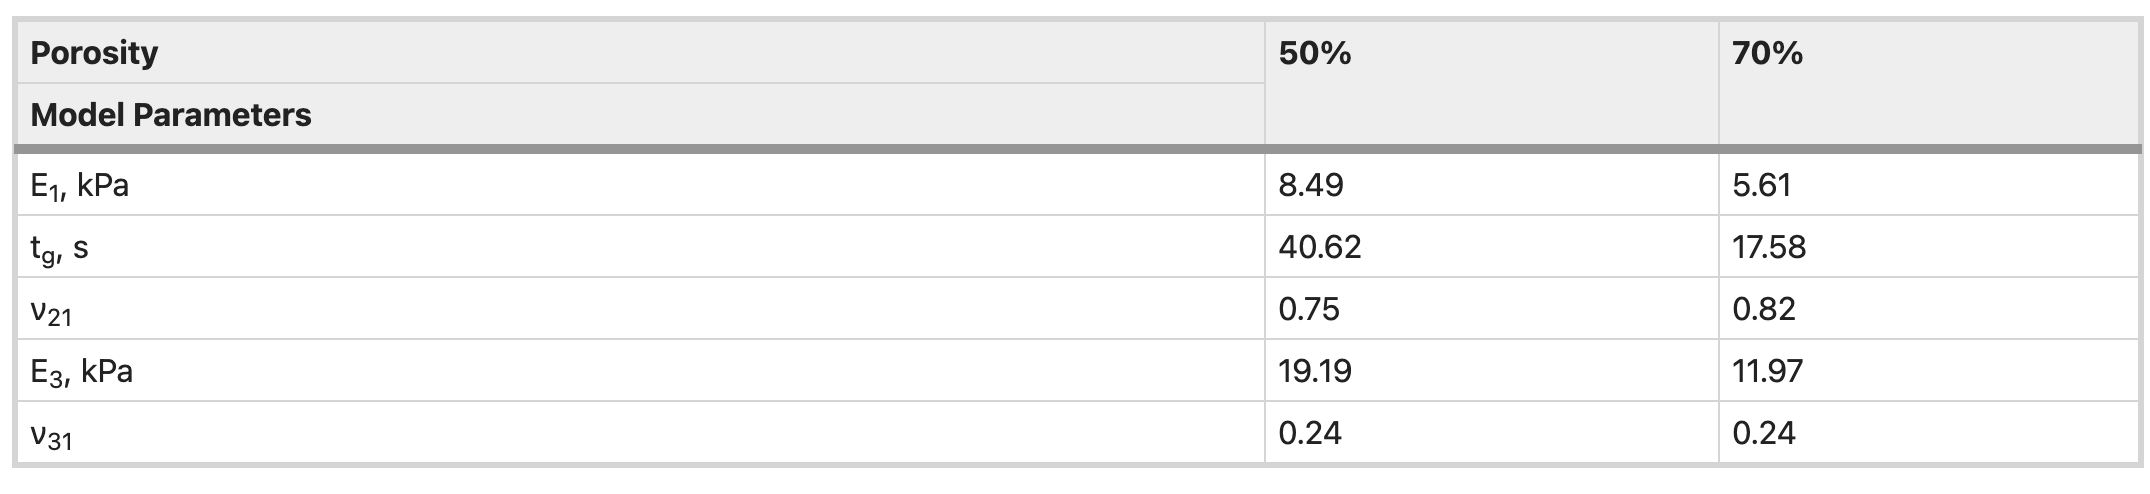

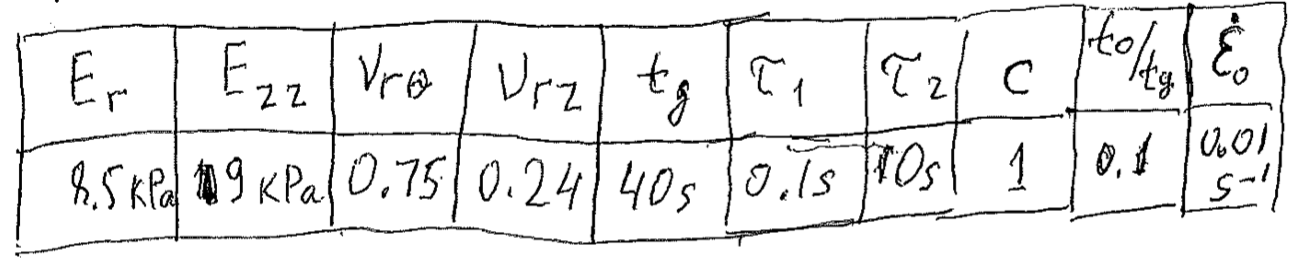

# Simple Laplace Model Inversion
## $$\begin{align} F(s)&=\frac{1}{s-a} \\ f(t)&={\mathrm{e}}^{a t}=\exp{\left(a t\right)} \end{align}$$

<IPython.core.display.Javascript object>

It took 0.0000 sec to evaluate the Laplace space func for 100 input s vals.
It took 0.0042 sec to numerically invert Laplace the func for 999 input times.


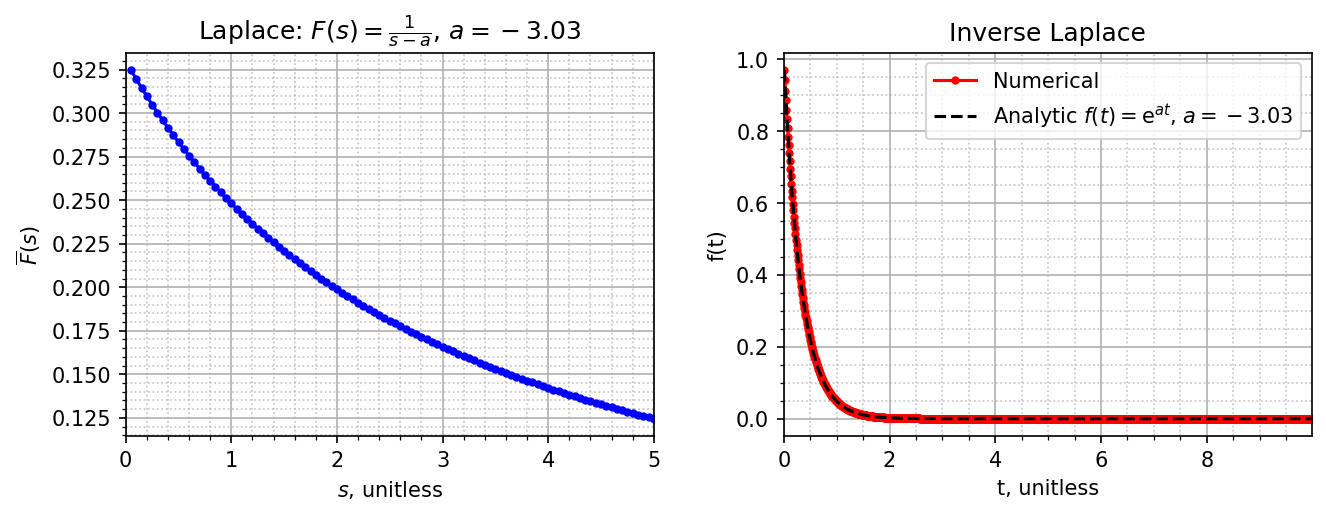

In [ ]:
#@markdown Simple Laplace - Numerical Inversion

importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
times=np.arange(0.1,100,0.1)/10000.0*10
times=np.arange(0.1,100,0.1)/100.0*10

input_times = times
plot_times  = times
input_times_anal = input_times
plot_times_anal = plot_times/1  #tg=1


# \rm gives roman style letters, which is indicative of a constant
#@markdown $$ F(s)=\frac{1}{s-a} $$
#@markdown $$ f(t)={\mathrm{e}}^{a t}=\exp{\left(a t\right)} $$.
a = -3.03 #@param {type:"number"}
funcs = lambda s: 1/(s-a)
inv_funcs_anal = lambda t: np.exp(a*t)
plot_props = {
    "t":        {"y":{"name":r"f(t)"}, "x":{"name":r"t, unitless", "scale":"linear"}},
    "s":        {"y":{"name":r"$\overline{F}(s)$"},  "x":{"name":r"$s$, unitless"}, 
                 "eqn":{"text":r"$F(s)=\frac{1}{s-a}$, $a="+str(a)+r"$"}},
    "t_anal":   {"eqn":{"text":r"$f(t)={\mathrm{e}}^{a t}$, $a="+str(a)+r"$"}},
}
input_s = np.arange(0.05, 5.05, 0.05)


_=plotting.plot_laplace_analysis(funcs=funcs, plot_props=plot_props, input_s=input_s, 
                                 input_times=input_times, plot_times=plot_times, time_const=1, 
                                 input_times_anal=input_times_anal, plot_times_anal=plot_times_anal, inv_funcs_anal=inv_funcs_anal,
                                 plot_mode="simple")


# Cohen Model Inversion

## Cohen Equations

### Cohen Laplace Solution
$$
\begin{align}
\tilde{\varepsilon}_{zz}&=\dot{\varepsilon}_{0} \cdot t_{g} \cdot \frac{1-\exp \left(-s \cdot t_{0} / t_{g}\right)}{s^{2}} \\
\widetilde{F(s)}&=\tilde{\varepsilon}_{z z} \cdot \frac{C_{1} I_{0}[\sqrt{s}]-C_{2} \cdot C_{0} \cdot \frac{I_{1}[\sqrt{s}]}{\sqrt{s}}}{I_{0}[\sqrt{s}]-C_{0} \cdot \frac{I_{1}[\sqrt{s}]}{\sqrt{s}}} \\
&=\dot{\varepsilon}_{0} t_{g} \left( \frac{1-\exp \left(-s \frac{t_{0}}{t_{g}}\right)}{s^{2}} \right) \left( \frac{C_{1} I_{0}\left[\sqrt{s}\right]-C_{2} C_{0} \frac{I_{1}\left[\sqrt{s}\right]}{\sqrt{s}}}{I_{0}\left[\sqrt{s}\right]-C_{0} \cdot \frac{I_{1}\left[\sqrt{s}\right]}{\sqrt{s}}}\right)
\end{align}
$$


### Cohen Inversion (Time) Solution

$$
\large{
\begin{align}
f(t) =
\begin{cases}   
E_3 \dot{\varepsilon}_0 t   &+& E_1 \dot{\varepsilon}_0 t_g \Delta_3 & \left( {\frac{1}{8} - \sum\limits_{\alpha_n^2}^{\infty} } \frac{\exp \left(-\frac{\alpha_n^2 t}{t_{g}}\right)}{\alpha_{n}^{2}\left(\Delta_2^2 \alpha_n^2-\frac{\Delta_1}{1+v_{21}}\right)}\right), & t \lt t_0 \\ 
E_3 \dot{\varepsilon}_0 t_0 &-& E_1 \dot{\varepsilon}_0 t_g \Delta_3 & \left( \sum\limits_{\alpha_n^2}^{\infty} \frac{\exp{\left( -\frac{\alpha_n^2 t}{t_g} \right) } - \exp{\left(-\frac{\alpha_n^2\left(t-t_0\right)}{t_{g}} \right)}}{\alpha_{n}^{2}\left(\Delta_2^2 \alpha_n^2-\frac{\Delta_1}{1+v_{21}}\right)} \right), & t \geq t_0
\end{cases}
\end{align}}
$$




### Constant definitions (i.e. $\Delta_n$)
\begin{align}
\Delta_{1}&=1-v_{21}-2 v_{31}^{2} \frac{E_1}{E_3} \\
\Delta_{2}&=\left(1-v_{31}^{2} \frac{E_1}{E_3}\right) /\left(1+v_{21}\right) \\
\Delta_{3}&=\left(1-2 v_{31}^{2}\right) \frac{\Delta_{2}}{\Delta_{1}} \\
&= \left(1-2 v_{31}^{2}\right) \frac{\left(1-v_{31}^{2} \frac{E_1}{E_3}\right) /\left(1+v_{21}\right)}{1-v_{21}-2 v_{31}^{2} \frac{E_1}{E_3}}
=  \frac{\left(1-2 v_{31}^{2}\right) \left(1-v_{31}^{2} \frac{E_1}{E_3}\right) }{ \left( 1-v_{21}-2 v_{31}^{2} \frac{E_1}{E_3} \right) \left(1+v_{21}\right)}
\\\\
\end{align}
  

### Expand time solution denominator eqns
$$
\begin{align}
\Delta_2^2 \alpha_n^2-\frac{\Delta_1}{1+v_{21}} &= \alpha_n^2 \frac{\left(1-v_{31}^{2} \frac{E_1}{E_3}\right)^2}{ \left(1+v_{21}\right)^2} -\frac{1-v_{21}-2 v_{31}^{2} \frac{E_{1}}{E_{3}}}{1+v_{21}} \\
&= \frac{1}{1+v_{21}} \left( \alpha_n^2 \frac{\left(1-v_{31}^{2} \frac{E_1}{E_3}\right)^2}{ \left(1+v_{21}\right)^2} -1 +v_{21} +2 v_{31}^{2} \frac{E_1}{E_3} \right) \\
&= \frac{1}{1+v_{21}} \left( \alpha_n^2 \left( \frac{ 1 -2v_{31}^{2}\frac{E_1}{E_3} +v_{31}^{4} \frac{E_1^2}{E_3^2} }{ 1+2v_{21}+v_{21}^2} \right) -1 +v_{21} +2 v_{31}^{2} \frac{E_1}{E_3}  \right)
\end{align}
$$

## Numerical Cohen Inversion

<IPython.core.display.Javascript object>

It took 0.0019 sec to evaluate the Laplace space func for 1097 input s vals.
It took 0.4001 sec to numerically invert Laplace the func for 1001 input times.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:2817: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,t0_tg,tg,strain_rate,E1,E3,v21,v31,Δ1,Δ2,Δ3,C11,C12,C13,C33,C0,C1,C2
CohenModelModified - Line #1,0.246184,1,0.01,8.5,19,0.75,0.240,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified - Line #2,0.246184,1,0.01,8.5,19,0.75,0.500,0.026316,0.507519,9.642857,163.928571,159.071429,161.500000,180.500000,0.029630,7.823529,7.823529
CohenModelModified - Line #3,0.246184,1,0.01,8.5,19,0.75,0.747,-0.249271,0.428780,0.199566,-14.621131,-19.478274,-25.472256,-19.055550,-0.332200,6.110283,18.138071


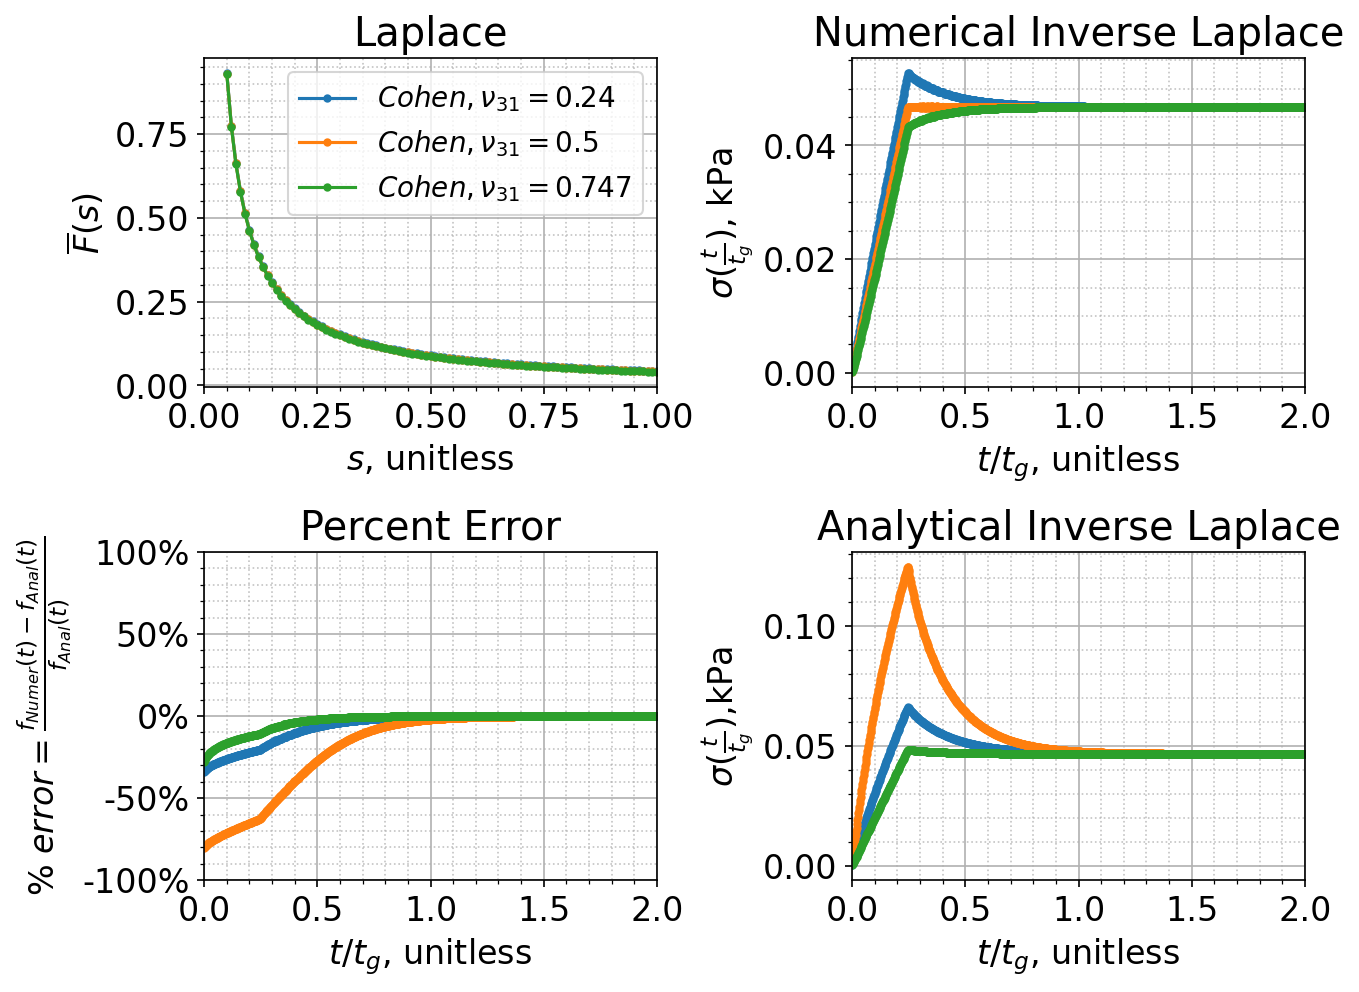

In [ ]:
#@title Straightforward Numerical Inversion
importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import CohenModel, CohenModel1998, getCohenModelModified

E3_vals=[3.5, 8.5]
VPEs = [(getCohenModelModified(v31=v31_val, tg=1), r"$Cohen, \nu_{31}"+f"={v31_val}$") for v31_val in v31_vals ]

tg = VPEs[0][0].tg

"""
func = []
import copy
func.append(vpe.laplace_value)
vpeB = copy.deepcopy(vpe)
vpeB.Vrtheta =  0.7
func.append(vpeB.laplace_value)
"""

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
#plot_times = np.arange(0.01, 1.001, 0.001)*tg
plot_times = np.linspace(0.001, 2, num=1001, endpoint=True)*tg
#input_times = np.concatenate((plot_times, np.array([5,10,20])*tg))
input_times = plot_times
input_times_anal = input_times
plot_times_anal = plot_times/tg
#func = vpe.laplace_value
func = [vpe.laplace_value for vpe, label in VPEs]
inv_funcs_anal = [vpe.inverted_value for vpe, label in VPEs]
func_labels = [label for vpe, label in VPEs]
func_name = {"t":r"$\sigma(\frac{t}{t_g})$", "s":r"$\overline{\sigma}(s)$"}
plot_props = {
    "t":        {"y":{"name":r"$\sigma(\frac{t}{t_g})$, "+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
    "s":        {"y":{"name":r"$\overline{F}(s)$"},  "x":{"name":r"$s$, unitless"}},
    "t_anal":   {"y":{"name":r"$\sigma(\frac{t}{t_g})$,"+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
}
plot_s = np.linspace(0.05, 1, num=96, endpoint=True)+0j
plot_s_s = np.linspace(0.0005, 1, num=1000, endpoint=True)+0j # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s,
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    input_times_anal=input_times_anal, plot_times_anal=plot_times_anal, inv_funcs_anal=inv_funcs_anal,
    #model_name = VPEs[0][0].get_model_name(), 
    do_plot_laplace_times_s=False,
    func_labels = func_labels)

for ind, ((vpe, label), laplace_vals, inverted_vals_numerical, inverted_vals_analytical) in enumerate(zip(VPEs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all)):
    itemindex = np.abs(input_times/vpe.tg - vpe.t0_tg).argmin()
    display(IPython.display.Latex(fr"\text{{ \#{ind+1}) {vpe.get_model_name()} with }} {label.replace('$','')}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[itemindex]/vpe.tg:.3f}, \quad {plot_props['t']['y']['name'].replace('$','')}={inverted_vals_numerical[itemindex]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[-1]/vpe.tg:.3f}, \quad {plot_props['t']['y']['name'].replace('$','')}={inverted_vals_numerical[-1]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} s={input_s[0]:.3f}, \quad s\cdot{plot_props['s']['y']['name'].replace('$','')}={laplace_vals[0]*input_s[0]:.3f}"))
    #display(vpe.alpha2_vals)

#df_params = pd.DataFrame(vpe.get_var_dict(),index=[vpe.get_model_name()])
#df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
#df_params = pd.DataFrame([{**vpe.get_var_dict(), **{"lab":label}} for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)

<IPython.core.display.Javascript object>

It took 0.0022 sec to evaluate the Laplace space func for 1097 input s vals.
It took 0.4175 sec to numerically invert Laplace the func for 1001 input times.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:2817: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,t0_tg,tg,strain_rate,E1,E3,v21,v31,Δ1,Δ2,Δ3,C11,C12,C13,C33,C0,C1,C2
CohenModelModified - Line #1,1000,1,0.01,8.5,19,0.75,0.240,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified - Line #2,1000,1,0.01,8.5,19,0.75,0.500,0.026316,0.507519,9.642857,163.928571,159.071429,161.500000,180.500000,0.029630,7.823529,7.823529
CohenModelModified - Line #3,1000,1,0.01,8.5,19,0.75,0.747,-0.249271,0.428780,0.199566,-14.621131,-19.478274,-25.472256,-19.055550,-0.332200,6.110283,18.138071


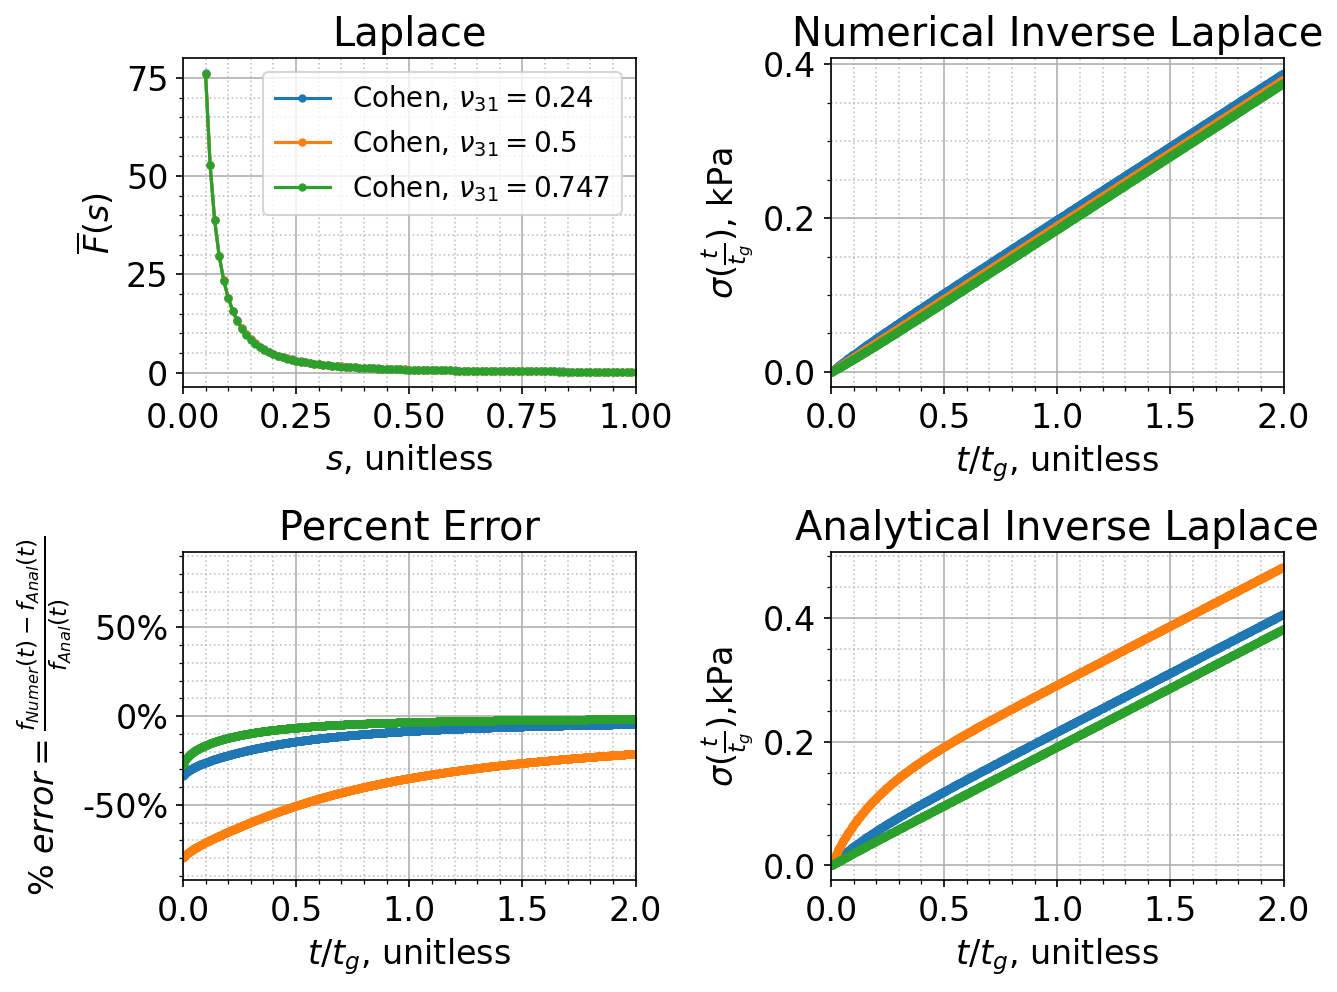

In [ ]:
#@title # Compare Cohen inversion if $t_0\to \infty$ 
importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import CohenModel, CohenModel1998, getCohenModelModified

v31_vals=[0.24, 0.5, 0.747]
VPEs = [(getCohenModelModified(v31=v31_val, t0_tg=1000, tg=1), r"Cohen, $\nu_{31}"+f"={v31_val}$") for v31_val in v31_vals ]

tg = VPEs[0][0].tg


# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
#plot_times = np.arange(0.01, 1.001, 0.001)*tg
plot_times = np.linspace(0.001, 2, num=1001, endpoint=True)*tg
#input_times = np.concatenate((plot_times, np.array([5,10,20])*tg))
input_times = plot_times
input_times_anal = input_times
plot_times_anal = plot_times/tg
func = [vpe.laplace_value for vpe, label in VPEs]
inv_funcs_anal = [vpe.inverted_value for vpe, label in VPEs]

#func = [ (lambda s: s*vpe.laplace_value(s, eps_zz=vpe.strain_rate * tg  / (s*s) ))  for vpe, label in VPEs]
#h = 1e-6
#inv_funcs_anal = [ (lambda t: (vpe.inverted_value(t+h)-vpe.inverted_value(t-h))/(2*h)) for vpe, label in VPEs]
#func = [ (lambda t: get_nth_gradient(vpe.inverted_value(t), t )) for vpe, label in VPEs]
#inv_funcs_anal = [ (lambda t: get_nth_gradient(vpe.inverted_value(t), t )) for vpe, label in VPEs]


func_labels = [label for vpe, label in VPEs]
plot_props = {
    "t":        {"y":{"name":r"$\sigma(\frac{t}{t_g})$, "+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
    "s":        {"y":{"name":r"$\overline{F}(s)$"},  "x":{"name":r"$s$, unitless"}},
    "t_anal":   {"y":{"name":r"$\sigma(\frac{t}{t_g})$,"+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
}
plot_s = np.linspace(0.05, 1, num=96, endpoint=True)+0j
plot_s_s = np.linspace(0.0005, 1, num=1000, endpoint=True)+0j # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s,
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    input_times_anal=input_times_anal, plot_times_anal=plot_times_anal, inv_funcs_anal=inv_funcs_anal,
    #model_name = VPEs[0][0].get_model_name(), 
    do_plot_laplace_times_s=False,
    func_labels = func_labels)

for ind, ((vpe, label), laplace_vals, inverted_vals_numerical, inverted_vals_analytical) in enumerate(zip(VPEs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all)):
    #itemindex = np.abs(input_times/vpe.tg - vpe.t0_tg).argmin()
    #itemindex = np.abs(input_times/vpe.tg - 10/40.26).argmin()
    # Closest to original t0_tg (under ramped-flat) without going over
    itemindex = np.abs(input_times/vpe.tg - 10/40.26 + 1e9*(input_times/vpe.tg>10/40.26)).argmin()
    display(IPython.display.Latex(fr"\text{{ \#{ind+1}) {vpe.get_model_name()} with }} {label.replace('$','')}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[itemindex]/vpe.tg:.3f}, \quad {plot_props['t']['y']['name'].replace('$','')}={inverted_vals_numerical[itemindex]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[-1]/vpe.tg:.3f}, \quad {plot_props['t']['y']['name'].replace('$','')}={inverted_vals_numerical[-1]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} s={input_s[0]:.3f}, \quad s\cdot{plot_props['s']['y']['name'].replace('$','')}={laplace_vals[0]*input_s[0]:.3f}"))
    


#df_params = pd.DataFrame(vpe.get_var_dict(),index=[vpe.get_model_name()])
#df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
#df_params = pd.DataFrame([{**vpe.get_var_dict(), **{"lab":label}} for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/

Plot 0, line #0, start: 0.1968, final: 0.1968
Plot 0, line #1, start: 0.1900, final: 0.1900
Plot 0, line #2, start: 0.1861, final: 0.1861
Plot 1, line #0, start: 0.1900, final: 0.1900
Plot 1, line #1, start: 0.1900, final: 0.1900
Plot 1, line #2, start: 0.1900, final: 0.1900
Plot 2, line #0, start: 0.1965, final: 0.1965
Plot 2, line #1, start: 0.1890, final: 0.1890
Plot 2, line #2, start: 0.1859, final: 0.1859
Plot 3, line #0, start: 0.1900, final: 0.1900
Plot 3, line #1, start: 0.1900, final: 0.1900
Plot 3, line #2, start: 0.1900, final: 0.1900


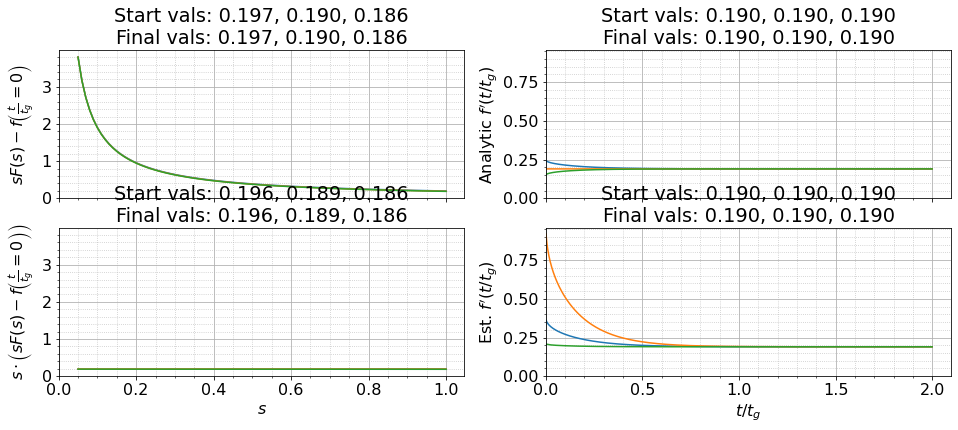

In [ ]:
#@title # Compare $d/dt$ of Cohen inversion if $t_0\to \infty$ 

#laplace_vals_all = [laplace_vals_all_it[0:len(plot_s)] for laplace_vals_all_it in laplace_vals_all]
fig = plt.figure(figsize=(16,6))
axes = fig.subplots(nrows=2, ncols=2, sharex="col", sharey="col")
for ax in axes.flat:
    ax.grid(which="major")  # set major grid lines
    ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

    
for ind, (vpe, label) in enumerate(VPEs):
    #axes.flat[0].plot(input_s, laplace_vals_all[ind]*input_s)
    y_val = laplace_vals_all[ind][0:len(plot_s)] * plot_s[0:len(plot_s)]
    axes.flat[0].plot(plot_s, np.real_if_close(y_val) )
    axes.flat[0].set_ylabel(r"$sF(s)-f\left(\frac{t}{t_g}=0\right)$")
    axes.flat[2].plot(plot_s, np.real_if_close(y_val * plot_s[0:len(plot_s)] - inverted_vals_analytical_all[ind, 0]) )
    axes.flat[2].set_ylabel(r"$s\cdot\left(sF(s)-f\left(\frac{t}{t_g}=0\right)\right)$")

    axes.flat[1].plot(input_times,      get_nth_gradient(np.real_if_close(inverted_vals_numerical_all[ind, :]),  input_times),"-")
    axes.flat[1].set_ylabel(r"Analytic $f'(t/t_g)$")
    axes.flat[3].plot(input_times_anal, get_nth_gradient(np.real_if_close(inverted_vals_analytical_all[ind, :]), input_times_anal),"-")
    axes.flat[3].set_ylabel(r"Est. $f'(t/t_g)$")
    
    axes.flat[3].set_xlabel(r"$t/t_g$")
    axes.flat[2].set_xlabel(r"$s$")

for ind, ax in enumerate( axes.flat ):
    #ax.set_xlim([input_times[0], input_times[-1]])
    ax.set_xlim([0, None])
    ax.set_ylim([0, None])
    finals = [[None] * len(ax.lines)]*2
    for ind2, line in enumerate(ax.lines):
        finals[0][ind2] = np.real_if_close(line.get_ydata()[0])
        finals[-1][ind2] = np.real_if_close(line.get_ydata()[-1])
        print( f"Plot {ind}, line #{ind2}, start: {finals[0][ind2]:0.4f}, final: {finals[-1][ind2]:0.4f}" )
    ax.set_title("Start vals: "+ ", ".join([f"{start_val:0.3f}" for start_val in finals[0]]) + "\n"
                 "Final vals: "+ ", ".join([f"{final_val:0.3f}" for final_val in finals[-1]]) 
                 )

### Cohen inversion varying $\nu_{31}$

<IPython.core.display.Javascript object>

It took 0.0053 sec to evaluate the Laplace space func for 1097 input s vals.
It took 0.3883 sec to numerically invert Laplace the func for 1001 input times.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:2817: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,t0_tg,tg,strain_rate,E1,E3,v21,v31,Δ1,Δ2,Δ3,C11,C12,C13,C33,C0,C1,C2
CohenModelModified - Line #1,1000,1,0.01,8.5,19,0.75,0.240,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified - Line #2,1000,1,0.01,8.5,19,0.75,0.500,0.026316,0.507519,9.642857,163.928571,159.071429,161.500000,180.500000,0.029630,7.823529,7.823529
CohenModelModified - Line #3,1000,1,0.01,8.5,19,0.75,0.747,-0.249271,0.428780,0.199566,-14.621131,-19.478274,-25.472256,-19.055550,-0.332200,6.110283,18.138071


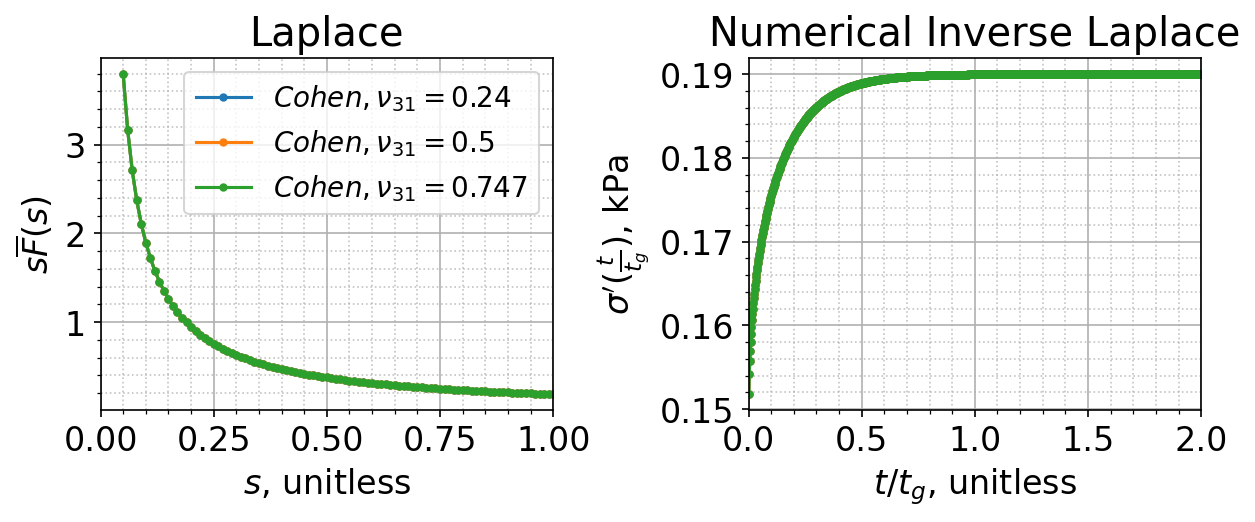

In [ ]:
importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import CohenModel, CohenModel1998, getCohenModelModified

v31_vals=[0.24, 0.5, 0.747]
VPEs = [(getCohenModelModified(v31=v31_val, t0_tg=1000, tg=1), r"Cohen, $\nu_{31}"+f"={v31_val}$") for v31_val in v31_vals ]

tg = VPEs[0][0].tg


# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
#plot_times = np.arange(0.01, 1.001, 0.001)*tg
plot_times = np.linspace(0.001, 2, num=1001, endpoint=True)*tg
#input_times = np.concatenate((plot_times, np.array([5,10,20])*tg))
input_times = plot_times
#func = vpe.laplace_value
func = [ (lambda s: s*vpe.laplace_value(s, eps_zz=vpe.strain_rate * tg  / (s*s) - vpe.inverted_value(0) )) 
          for vpe, label in VPEs]
func_labels = [label for vpe, label in VPEs]
plot_props = {
    "t":        {"y":{"name":r"$f'(\frac{t}{t_g})$, "+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
    "s":        {"y":{"name":r"$s\overline{F}(s)-f(0)$"},  "x":{"name":r"$s$, unitless"}},
    "t_anal":   {"y":{"name":r"$f'(\frac{t}{t_g})$,"+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
}
plot_s = np.linspace(0.05, 1, num=96, endpoint=True)+0j
plot_s_s = np.linspace(0.0005, 1, num=1000, endpoint=True)+0j # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s,
    input_times=input_times, plot_times=plot_times, time_const=tg,
    #model_name = VPEs[0][0].get_model_name(), 
    do_plot_laplace_times_s=False,
    func_labels = func_labels)

for ind, ((vpe, label), laplace_vals, inverted_vals_numerical, inverted_vals_analytical) in enumerate(zip(VPEs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all)):
    itemindex = np.abs(input_times/vpe.tg - vpe.t0_tg).argmin()
    display(IPython.display.Latex(fr"\text{{ \#{ind+1}) {vpe.get_model_name()} with }} {label.replace('$','')}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[itemindex]/vpe.tg:.3f}, \quad {plot_props['t']['y']['name'].replace('$','')}={inverted_vals_numerical[itemindex]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[-1]/vpe.tg:.3f}, \quad {plot_props['t']['y']['name'].replace('$','')}={inverted_vals_numerical[-1]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} s={input_s[0]:.3f}, \quad s\cdot{plot_props['s']['y']['name'].replace('$','')}={laplace_vals[0]*input_s[0]:.3f}"))


#df_params = pd.DataFrame(vpe.get_var_dict(),index=[vpe.get_model_name()])
#df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
#df_params = pd.DataFrame([{**vpe.get_var_dict(), **{"lab":label}} for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)

## Confirm $\nu_{31}$ has an effect on $F(s)$ on the imaginary axis, even though its effect on the real axis is minimal
It is weird that it has a minimal effect on the real axis even though all the intermediate steps ($\Delta_1$, $\Delta_2$, $\Delta_3$, $C_0$, $C_1$, $C_2$) are affected.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


,"v31=0.24, Re","v31=0.24, Im","v31=0.50, Re","v31=0.50, Im","v31=0.74, Re","v31=0.74, Im"
0.00+0.10j,-0.153326,-19.000529,-0.233863,-18.998081,-0.277855,-18.996881
0.00+11.20j,-0.137962,-0.039242,-0.118563,-0.023068,-0.107273,-0.011882
0.00+22.30j,-0.006476,0.013171,-0.004632,0.011060,-0.003344,0.009765
0.00+33.40j,-0.011245,-0.008563,-0.009411,-0.006454,-0.008277,-0.004995
0.00+44.50j,-0.005264,0.004634,-0.004055,0.003894,-0.003226,0.003441
0.00+55.60j,-0.001659,-0.002885,-0.001412,-0.002249,-0.001266,-0.001815
0.00+66.70j,-0.003882,0.001289,-0.003048,0.001134,-0.002482,0.001053
0.00+77.80j,-0.000058,-0.000483,-0.000058,-0.000381,-0.000061,-0.000312
0.00+88.90j,-0.002457,-0.000206,-0.001948,-0.000103,-0.001605,-0.000020
0.00+100.00j,-0.000140,0.000477,-0.000100,0.000380,-0.000070,0.000315


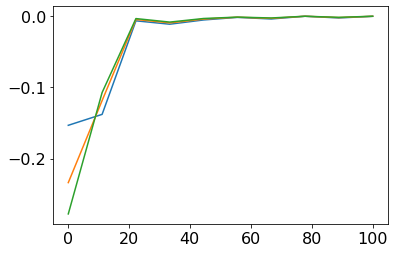

In [ ]:
t0_tg = 10 / 40.62
tg = 40.62  # sec
strain_rate = 0.01  # per sec
E1 = 8.5  # kPa
E3 = 19   # kPa
v21 = 0.75  # like Vrtheta
#v31 = 0.24  # like Vrz

s = np.linspace(0.1,100,10, endpoint=True)*1j
eps_zz = strain_rate * tg * (1 - np.exp(-t0_tg * s)) / (s*s)

Fs = {}
fig = plt.figure()
axs = fig.axes
for v31 in [0.24, 0.5, 0.74]:
    v31sq = v31 * v31

    delta1 = 1 - v21 - 2*v31sq*E1/E3
    delta2 = (1 - v31sq*E1/E3)/(1+v21)
    delta3 = (1 - 2*v31sq)*delta2/delta1

    C11 = E1*(1 - v31*v31 * E1/E3) / ((1+v21) * delta1)
    C12 = E1*(v21+v31*v31 * E1/E3) / ((1+v21) * delta1)
    C13 = E1*v31 / delta1
    C33 = E3 * (1 + 2*v31*v31 * E1/E3 / delta1)   # C44==C31

    C0 = (C11-C12)/C11
    C1 = (2*C33 + C11 + C12 - 4*C13) / (C11-C12)
    C2 = 2 * (C33*(C11-C12) + C11*(C11+C12-4*C13)
                + 2*C13*C13) / (C11-C12)**2




    I1rts_s = I1(np.sqrt(s)) / np.sqrt(s)
    I0rts = I0(np.sqrt(s))

    # F is the load intensity
    F = (C1*I0rts - C2*C0*I1rts_s) / (I0rts - C0*I1rts_s) * eps_zz
    F = F * (C11-C12)/2
    #Fs.append(np.array([F.real, F.imag]))
    Fs[f"v31={v31:0.2f}, Re"]=F.real
    Fs[f"v31={v31:0.2f}, Im"]=F.imag
    plt.plot(np.abs(s),F)

#pd.DataFrame(np.array(Fs).T)
#pd.DataFrame(Fs).T
pd.DataFrame(Fs, index=[f"{s_val:.2f}" for s_val in s])
#, index=s 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[-890.17+0.j    0.  +0.j]
[-684.5+0.j    0. +0.j]
[-537.33-0.j    0.  +0.j]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-30.0, 50.0)

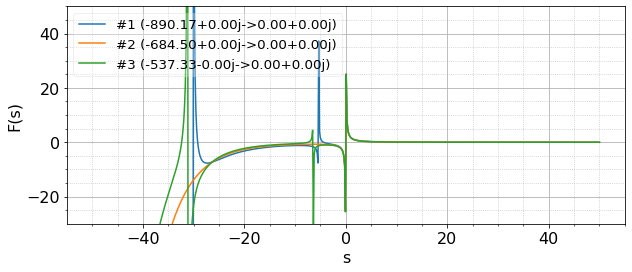

In [ ]:
#@title ## Plot Cohen over imaginary axis

importlib.reload(inverting)

plot_s = np.linspace(0.05, 2, num=1000, endpoint=True)
#plot_s = np.concatenate( [-plot_s, plot_s])
plot_s = np.linspace(-50+0j, 50+0j, num=666, endpoint=True)

t_new_anal = np.linspace(0.05, 100, num=1001, endpoint=True) 

F_s_recalcs = [
               #*[inverting.forward_laplace_transform(inverting.euler_inversion(VPEs[ind][0].laplace_value, t_new_anal), plot_s, times=t_new_anal ) for ind, _ in enumerate(VPEs) ],
               #*[inverting.forward_laplace_transform(inverted_vals_analytical_all[ind], plot_s, times=input_times_anal ) for ind, _ in enumerate(VPEs) ],
               *[VPEs[ind][0].laplace_value(plot_s) for ind, _ in enumerate(VPEs) ],

               #*[inverting.forward_laplace_transform(VPEs[ind][0].inverted_value, plot_s, times=np.linspace(0, 100, num=100001, endpoint=True) ) for ind, _ in enumerate(VPEs)],
               #*[laplace_vals_all[ind][0:len(plot_s)] for ind, _ in enumerate(VPEs) ],
               #*[inverting.forward_laplace_transform(inverted_vals_numerical_all[ind], plot_s, times=plot_times ) for ind, _ in enumerate(VPEs) ]
 
 ]

fig = plt.figure()
fig.set_figwidth(7.5)
fig.set_figwidth(10)
for ind, F_s_recalc in enumerate(F_s_recalcs):
    bounds = F_s_recalc[np.array([0,-1])]
    plt.plot(plot_s, F_s_recalc, label=f"#{ind+1} ({bounds[0]:5.2f}->{bounds[1]:5.2f})")
    print(bounds.round(2))

ax = fig.get_axes()[0]
plt.xlabel("s")
plt.ylabel("F(s)")
plt.legend(framealpha=0.3, fontsize='small', loc="upper left")
ax.grid(which="major")  # set major grid lines
ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
#ax.set_xlim([-0.5,None])
ax.set_ylim([-30, 50])




#F_s_recalcs
# (10.207851041127167*I0rts - 6.362394053190878*I1rts_s) / (I0rts - 0.2037125075633159*I1rts_s)
# (10.21*I0rts - 6.36*I1rts_s) / (I0rts - 0.204*I1rts_s)


In [ ]:
#VPEs = [(viscoporoelastic_model.CohenModel1998(), fr"$Cohen$") ]
for VPE, name in VPEs:
    print()
    print(name)
    t0_tg, tg, strain_rate, E1, E3, v21, v31 = vpe.get_predefined_constants()
    t0=t0_tg*tg
    delta1, delta2, delta3, C11, C12, C13, C33, C0, C1, C2 = vpe.get_calculable_constants()
    vpe.setup_constants(bessel_len=100)
    alpha2_vals = vpe.alpha2_vals

    print(f"strain_rate*t0*(2*C1-C2*C0)/(2-C0)=\t{strain_rate*t0*(2*C1-C2*C0)/(2-C0)}")
    print(f"strain_rate*t0*2*(1+v21)*E3/E1=\t{strain_rate*t0*2*(1+v21)*E3/E1}")
    print(f"strain_rate*t0*E3=\t{strain_rate*t0*E3}")
    print(f"2*(1+v21)*E3/E1=\t{strain_rate*t0*2*(1+v21)*E3/E1}")
    print(f"(2*C1-C2*C0)/(2-C0)=\t{(2*C1-C2*C0)/(2-C0)}")
    print(f"E3=\t{E3}")


<IPython.core.display.Javascript object>


$Cohen$
strain_rate*t0*(2*C1-C2*C0)/(2-C0)=	1.8999999999999986
strain_rate*t0*2*(1+v21)*E3/E1=	1.9000000000000001
strain_rate*t0*E3=	1.9000000000000001
2*(1+v21)*E3/E1=	1.9000000000000001
(2*C1-C2*C0)/(2-C0)=	18.999999999999986
E3=	19

$Cohen, E_1=3.5$
strain_rate*t0*(2*C1-C2*C0)/(2-C0)=	1.8999999999999986
strain_rate*t0*2*(1+v21)*E3/E1=	1.9000000000000001
strain_rate*t0*E3=	1.9000000000000001
2*(1+v21)*E3/E1=	1.9000000000000001
(2*C1-C2*C0)/(2-C0)=	18.999999999999986
E3=	19


In [ ]:
"""
(2*C33*(C11+C12)-4*C13*C13)/(C11*(C11-C12)), 2*C1-C2*C0
(C11+C12)/C11, 2-C0

E3+2*v31*v31*E1/delta1, C33
E1/(1+v21), C11-C12
E1/delta1, C11+C12
strain_rate*t0*2*E3/E1*(1+v21)
"""

VPEs = [(CohenModel(), fr"$Cohen$"), (getCohenModelModified(), fr"$Cohen$2") ]
[VPE.laplace_value for VPE, name in VPEs]
print(CohenModel.E3)

<IPython.core.display.Javascript object>

19


## Reproduce simple 1998 Cohen model, same parameters as paper

<IPython.core.display.Javascript object>

[3.15377282e-08 4.46053371e-03 1.67565916e+00 1.67670166e+00
 1.67328351e+00 1.00000000e+00]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply
/content/gdrive/MyDrive/Computer Backups/Rahul Yerrabelli drive/Academics/Work/SpectorMechanicsLab/SpectorResearch/Computations/SpectorLog/Yerrabelli-Spector-Porelastic-Model-Code/src/viscoporoelastic_model.py:1205: RuntimeWarning: overflow encountered in exp
  for alpha2_N in alpha2_vals
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


,t0_tg,tg,strain_rate,E1,E3,v21,v31,Δ1,Δ2,Δ3,C11,C12,C13,C33,C0,C1,C2
CohenModel1998 - Line #1,1,1,0.01,5,1,0.3,0,0.7,0.769231,1.098901,5.494505,1.648352,0.0,1.0,0.7,2.377143,5.826122


0.0052000000000000015

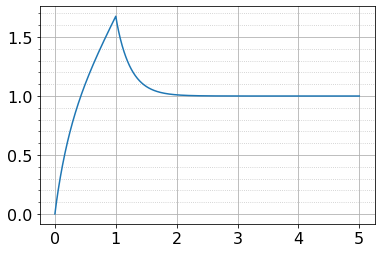

In [ ]:
importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import CohenModel, CohenModel1998, getCohenModelModified

importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)

VPEs = [(viscoporoelastic_model.CohenModel1998(), 
         fr"$Cohen$") ]

t0_tg, tg, strain_rate, E1, E3, v21, v31 = VPEs[0][0].get_predefined_constants()
t0=t0_tg*tg
delta1, delta2, delta3, _, _, _, _, C0, C1, C2 = VPEs[0][0].get_calculable_constants()
#VPEs[0][0].inverted_value(t=0)
VPEs[0][0].setup_constants(bessel_len=100)
alpha2_vals = VPEs[0][0].alpha2_vals

#sum(1/(alpha2_vals*(delta2*delta2*alpha2_vals - delta1/(1+v21)))) => 0.9785392135865333 for len=10,000
"""
print(E3)
print(sum(np.exp(-alpha2_vals * t0_tg)/(alpha2_vals*(delta2*delta2*alpha2_vals - delta1/(1+v21)))))
#alpha2_vals
print((1 - 2*v31*v31*E1/E3) / (1 - v21 - 2*v31*v31*E1/E3))
print((1 - v31*v31*E1/E3) / (1 - v21 - 2*v31*v31*E1/E3))
"""

input_times = np.linspace(0.00, 5, num=1001, endpoint=True) * tg
#output = VPEs[0][0].inverted_value(t=input_times)
t=input_times
output1 = E3*strain_rate*np.minimum(t, t0)
exp = np.exp
output2 = E1*strain_rate*tg*delta3*(1/8*(t<t0) - sum( (exp(-alpha2_N * t/tg) - exp(-alpha2_N * (t-t0)/tg )*(t>=t0) ) / (alpha2_N*(delta2*delta2*alpha2_N - delta1/(1+v21)))
                for alpha2_N in alpha2_vals
    ))
output = output1 + output2 #+ 4*E3*strain_rate*t0*(t<t0)
output = VPEs[0][0].inverted_value(t)
print(VPEs[0][0].inverted_value(t=np.array([0,0.001,t0*0.999,t0,t0*1.001,10]))/(E3*strain_rate*t0))

plt.figure()
plt.plot(input_times/(t0),output/(E3*strain_rate*t0) )
plt.grid(which="major")  # set major grid lines
plt.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
plt.axes().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)



<IPython.core.display.Javascript object>

[3.15377282e-08 4.46053371e-03 1.67565916e+00 1.67670166e+00
 1.67328351e+00 1.00000000e+00]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


,t0_tg,tg,strain_rate,E1,E3,v21,v31,Δ1,Δ2,Δ3,C11,C12,C13,C33,C0,C1,C2
CohenModel1998 - Line #1,1,1,0.01,5,1,0.3,0,0.7,0.769231,1.098901,5.494505,1.648352,0.0,1.0,0.7,2.377143,5.826122


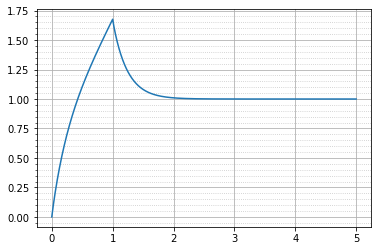

In [8]:
E3_vals=[3.5, 8.5]
VPEs = [(getCohenModelModified(v31=v31_val, tg=1), r"$Cohen, \nu_{31}"+f"={v31_val}$") for v31_val in v31_vals ]

tg = VPEs[0][0].tg

"""
func = []
import copy
func.append(vpe.laplace_value)
vpeB = copy.deepcopy(vpe)
vpeB.Vrtheta =  0.7
func.append(vpeB.laplace_value)
"""

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
#plot_times = np.arange(0.01, 1.001, 0.001)*tg
plot_times = np.linspace(0.001, 2, num=1001, endpoint=True)*tg
#input_times = np.concatenate((plot_times, np.array([5,10,20])*tg))
input_times = plot_times
input_times_anal = input_times
plot_times_anal = plot_times/tg
#func = vpe.laplace_value
func = [vpe.laplace_value for vpe, label in VPEs]
inv_funcs_anal = [vpe.inverted_value for vpe, label in VPEs]
func_labels = [label for vpe, label in VPEs]
func_name = {"t":r"$\sigma(\frac{t}{t_g})$", "s":r"$\overline{\sigma}(s)$"}
plot_props = {
    "t":        {"y":{"name":r"$\sigma(\frac{t}{t_g})$, "+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
    "s":        {"y":{"name":r"$\overline{F}(s)$"},  "x":{"name":r"$s$, unitless"}},
    "t_anal":   {"y":{"name":r"$\sigma(\frac{t}{t_g})$,"+VPEs[0][0].inverted_value_units()}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
}
plot_s = np.linspace(0.05, 1, num=96, endpoint=True)+0j
plot_s_s = np.linspace(0.0005, 1, num=1000, endpoint=True)+0j # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s,
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    input_times_anal=input_times_anal, plot_times_anal=plot_times_anal, inv_funcs_anal=inv_funcs_anal,
    #model_name = VPEs[0][0].get_model_name(), 
    do_plot_laplace_times_s=False,
    func_labels = func_labels)

for ind, ((vpe, label), laplace_vals, inverted_vals_numerical, inverted_vals_analytical) in enumerate(zip(VPEs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all)):
    itemindex = np.abs(input_times/vpe.tg - vpe.t0_tg).argmin()
    display(IPython.display.Latex(fr"\text{{ \#{ind+1}) {vpe.get_model_name()} with }} {label.replace('$','')}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[itemindex]/vpe.tg:.3f}, \quad {plot_props['t']['y']['name'].replace('$','')}={inverted_vals_numerical[itemindex]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[-1]/vpe.tg:.3f}, \quad {plot_props['t']['y']['name'].replace('$','')}={inverted_vals_numerical[-1]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} s={input_s[0]:.3f}, \quad s\cdot{plot_props['s']['y']['name'].replace('$','')}={laplace_vals[0]*input_s[0]:.3f}"))
    #display(vpe.alpha2_vals)

#df_params = pd.DataFrame(vpe.get_var_dict(),index=[vpe.get_model_name()])
#df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
#df_params = pd.DataFrame([{**vpe.get_var_dict(), **{"lab":label}} for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)

## Splitting up Cohen into parts A and B

$$
\text{Separating out the constants so $A$, $B$, $X$, and $Y$ do not depend on $t$ } \\
\begin{align}
A &= E_3 \dot{\varepsilon}_0 t_g , &
B &= E_1 \dot{\varepsilon}_0 t_g \\ 
X &= \Delta_2^2 , &
Y &= \frac{\Delta_1}{1+\nu_{21}} \\
\end{align}
$$


$$
\begin{align}
f(t) &= 
\begin{cases}   
A\frac{t}{t_g}   &+ B \left( \frac{1}{8} - \sum_{\alpha_n^2} \frac{\exp \left(-\alpha_n^2 \frac{t}{t_g}\right)}{\alpha_{n}^{2}\left(X \alpha_n^2 - Y \right)}\right), & t \lt t_0 \\ 
A\frac{t_0}{t_g} &- B \left( \sum_{\alpha_n^2} \frac{\exp{\left( -\alpha_n^2 \frac{t}{t_g} \right) } - \exp{\left(-\alpha_n^2 \frac{t-t_0}{t_g} \right)}}{\alpha_{n}^{2}\left(X \alpha_n^2 - Y\right)} \right), & t \geq t_0
\end{cases} \\
\\
\text{if we assume dimensionless variables, i.e. }\\ 
\text{$t\leftarrow t/t_g$ and $t_0 \leftarrow  t_0/t_g$, thus } \\
f(t) &= 
\begin{cases}   
At   &+ B \left( \frac{1}{8} - \sum_{\alpha_n^2} \frac{\exp \left(-\alpha_n^2 t \right)}{\alpha_{n}^{2}\left(X \alpha_n^2 - Y \right)}\right), & t \lt t_0 \\ 
At_0 &- B \left( \sum_{\alpha_n^2} \frac{\exp{\left( -\alpha_n^2 t \right) } - \exp{\left( -\alpha_n^2 \left(t-t_0 \right) \right)}}{\alpha_n^2 \left(X \alpha_n^2 - Y\right)} \right), & t \geq t_0 \\
\end{cases} \\
\\
\\
\frac{\mathrm{d} f(t)} {\mathrm{d}t} &= 
\begin{cases}   
A   &- B \left( \sum_{\alpha_n^2} \frac{\exp \left(-\alpha_n^2 t \right)}{\alpha_n^2\left(X \alpha_n^2 - Y \right)}\right) \cdot -\alpha_n^2, & t \lt t_0 \\ 
0   &- B \left( \sum_{\alpha_n^2} \frac{\exp{\left( -\alpha_n^2 t \right) } - \exp{\left( -\alpha_n^2 \left(t-t_0 \right) \right)}}{\alpha_n^2 \left(X \alpha_n^2 - Y\right)} \right) \cdot -\alpha_n^2, & t \geq t_0
\end{cases} \\
&= 
\begin{cases}   
A   &+ B  \sum_{\alpha_n^2} \frac{\exp \left(-\alpha_n^2 t \right)}{X \alpha_n^2 - Y } , & t \lt t_0 \\ 
    &+ B  \sum_{\alpha_n^2} \frac{\exp{\left( -\alpha_n^2 t \right) } - \exp{\left( -\alpha_n^2 \left(t-t_0 \right) \right)}}{ X\alpha_n^2 - Y} , & t \geq t_0
\end{cases} \\
\\
\frac{\mathrm{d}^2 f(t)} {\mathrm{d}t^2} &= 
B \begin{cases}   
    \sum_{\alpha_n^2} -\alpha_n^2 \frac{\exp \left(-\alpha_n^2 t \right)}{X \alpha_n^2 - Y } , & t \lt t_0 \\ 
    \sum_{\alpha_n^2} -\alpha_n^2 \frac{\exp{\left( -\alpha_n^2 t \right) } - \exp{\left( -\alpha_n^2 \left(t-t_0 \right) \right)}}{ X\alpha_n^2 - Y} , & t \geq t_0
\end{cases} \\
\\
\text{for positive integers $m$ i.e. $m \in \{1,2,3 \dots\}$} \\
\frac{\mathrm{d}^{(m+1)} f(t)} {\mathrm{d}t^{(m+1)}} &= 
B \begin{cases}   
     \sum_{\alpha_n^2} \left(-\alpha_n^2 \right)^{m} \frac{\exp \left(-\alpha_n^2 t \right)}{X \alpha_n^2 - Y } , & t \lt t_0 \\ 
     \sum_{\alpha_n^2} \left(-\alpha_n^2 \right)^{m} \frac{\exp{\left( -\alpha_n^2 t \right) } - \exp{\left( -\alpha_n^2 \left(t-t_0 \right) \right)}}{ X\alpha_n^2 - Y} , & t \geq t_0
\end{cases} \\
\end{align}
$$

$f'(t)$ represents the derivative of $f(t)$
$$
\begin{align}
\L{f'(t)}&=sF(s)-f(0^-) \\
\L{f''(t)}&=s^2F(s)-sf(0^-)-f'(0^-) \\ 
\L{f'''(t)}&=s^3F(s)-s^2f(0^-)-sf'(0^-)-f''(0^-) \\ 
\L{f^{(m)}(t)}&=s^mF(s)-\sum_{n=m-1}^{0} s^nf^{(m-n-1)}(0^-) \\ 
\end{align}
$$

### Values of $A$ and $B$

In [ ]:
A = E3 * strain_rate * tg
B = E1 * strain_rate * tg
X = delta2**2
Y = delta1/(1+v21)
#print(f"A={A}, B={B}, X={X}, Y={Y}")
#print(f"A={A:0.3f}, B={B:0.3f}, X={X:0.3f}, Y={Y:0.3f}")
display(IPython.display.Math("\\\\".join([f"A={A:0.3f}", f"B={B:0.3f}", f"X={X:0.3f}", f"Y={Y:0.3f}"]) ))


<IPython.core.display.Javascript object>

A=7.7177999999999995, B=3.4527, X=0.3099190757284188, Y=0.11340751879699248


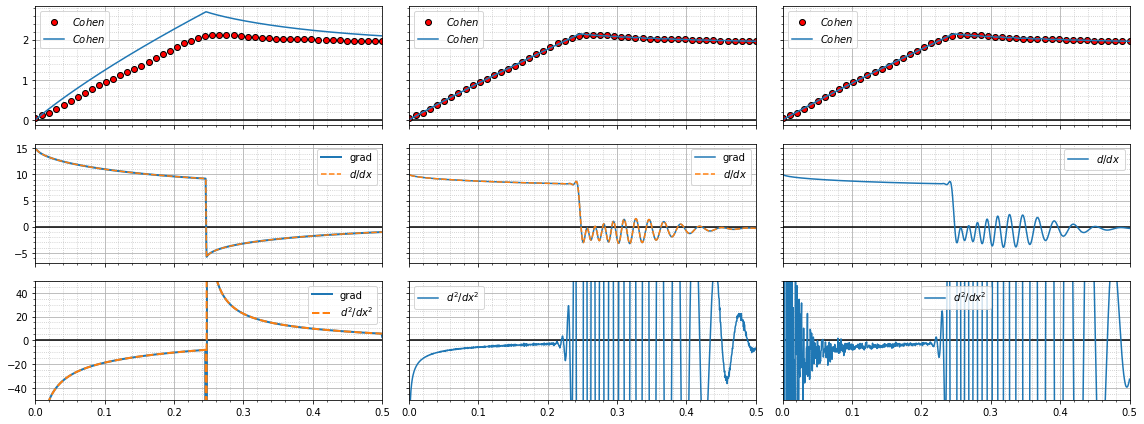

In [ ]:
#@title Derivative plot 1
importlib.reload(viscoporoelastic_model)

VPEs = [(viscoporoelastic_model.CohenModel(), fr"$Cohen$") ]

t0_tg, tg, strain_rate, E1, E3, v21, v31 = VPEs[0][0].get_predefined_constants()
t0=t0_tg*tg
delta1, delta2, delta3, _, _, _, _, C0, C1, C2 = VPEs[0][0].get_calculable_constants()



plot_times_tg, t_step = np.linspace(0.001, 0.5, num=1001, endpoint=True, retstep=True)
plot_times = plot_times_tg*tg

        

(s, ds)=np.linspace(start=1-50j, stop=1+50j, num=10000, endpoint=True, retstep=True)
#t1 = np.array([0.1, 0.2, 0.25, 0.3, 0.4, 0.5])
#t1 = np.concatenate( [np.array([0.246184]), np.linspace(start=0, stop=0.5, num=12)] )
t1 = np.linspace(start=0, stop=0.5, num=50)



fig = plt.figure(figsize=(16,6))
axes = fig.subplots(nrows=3, ncols=3, sharey="row", sharex=True)

for ax in axes.flat:
    ax.grid(which="major")  # set major grid lines
    ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.plot([plot_times_tg[0], plot_times_tg[-1] ], [0, 0],"k")

inverted_values_analy = []
inverted_values_numer = []
inverted_values_intnum = []
inverted_laplace_ddx = []
inverted_laplace_ddx2 = []
for ind, (vpe, name) in enumerate(VPEs):
    inverted_values_analy.append(  vpe.inverted_value(plot_times) )
    inverted_values_numer.append(  inverting.euler_inversion(vpe.laplace_value, plot_times_tg) )
    # The [...,None] index allows t1 to be either a single value (returns single value) or a matrix (returns matrix)
    laplace_val = vpe.laplace_value(s, dimensional=True) 
    expon_2pii = np.exp(s[...,None]*t1)/(2j*np.pi)
    inverted_values_intnum.append( np.real_if_close((np.sum(laplace_val * expon_2pii.T, axis=-1)*ds).T) )
    inverted_laplace_ddx.append(inverting.euler_inversion(
                       (lambda x: vpe.laplace_value(x)*x-0), plot_times_tg))
    inverted_laplace_ddx2.append(inverting.euler_inversion(
                       (lambda x: vpe.laplace_value(x)*x*x-x*np.diff(inverted_values_numer[ind][0:2])/t_step-0 ), plot_times_tg))

for ind, (vpe, name) in enumerate(VPEs):
    for ind2 in range(3):
        axes[0,ind2].plot(t1, inverted_values_intnum[ind], "ro", mec="k", mew=1, label=name )
    
    axes[0,0].plot(plot_times_tg, inverted_values_analy[ind], label=name )
    axes[1,0].plot(plot_times_tg, np.gradient(inverted_values_analy[ind], plot_times_tg), label="grad", lw=2 )
    axes[1,0].plot(get_midpoint(plot_times_tg), 
                   np.diff(inverted_values_analy[ind])/t_step, "--", label="$d/dx$" )
    axes[2,0].plot(plot_times_tg, 
                   np.gradient(np.gradient(inverted_values_analy[ind], plot_times_tg), plot_times_tg), 
                   label="grad", lw=2 )
    axes[2,0].plot(plot_times_tg[1:-1], 
                   get_diff2(inverted_values_analy[ind],t_step), "--", label="$d^2/dx^2$", lw=2 )
    """axes[2,0].plot( plot_times_tg[1:-1], 
                   np.diff(inverted_values_analy[ind],2)/np.diff(plot_times_tg,2), "-", label="$d/dx$" )
    axes[2,0].set_ylim([-5,5])"""

    axes[0,1].plot(plot_times_tg, inverted_values_numer[ind], label=name )
    axes[1,1].plot(plot_times_tg, np.gradient(inverted_values_numer[ind], plot_times_tg) , label="grad" )
    axes[1,1].plot(get_midpoint(plot_times_tg), 
                   np.diff(inverted_values_numer[ind])/np.diff(plot_times_tg), "--", label="$d/dx$" )
    axes[2,1].plot(plot_times_tg[1:-1], 
                   get_diff2(inverted_values_numer[ind],t_step), "-", label="$d^2/dx^2$" )
    """axes[0,0].plot(plot_times_tg, np.gradient(inverted_values_analy, plot_times_tg), label=name )"""

    axes[0,2].plot(plot_times_tg, inverted_values_numer[ind], label=name )
    axes[1,2].plot(plot_times_tg, inverted_laplace_ddx[ind], "-", label="$d/dx$" )
    axes[2,2].plot(plot_times_tg, inverted_laplace_ddx2[ind], "-", label="$d^2/dx^2$" )
    

for ax in axes.flat:
    ax.legend()

#axes[0,0].set_ylim([None,15])
axes[0,0].set_xlim([0,np.max(plot_times_tg)])
axes[2,0].set_ylim([-50,50])
plt.tight_layout()

<IPython.core.display.Javascript object>

A=7.7177999999999995, B=3.4527, X=0.3099190757284188, Y=0.11340751879699248


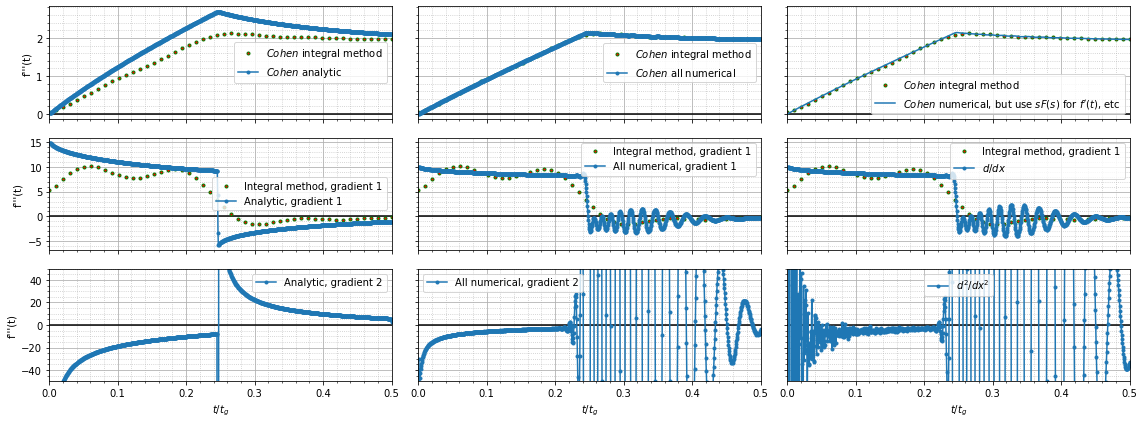

In [ ]:
#@title Derivative plot 2

importlib.reload(viscoporoelastic_model)

VPEs = [(viscoporoelastic_model.CohenModel(), fr"$Cohen$") ]

t0_tg, tg, strain_rate, E1, E3, v21, v31 = VPEs[0][0].get_predefined_constants()
t0=t0_tg*tg
delta1, delta2, delta3, _, _, _, _, C0, C1, C2 = VPEs[0][0].get_calculable_constants()

A = E3 * strain_rate * tg
B = E1 * strain_rate * tg
X = delta2**2
Y = delta1/(1+v21)
print(f"A={A}, B={B}, X={X}, Y={Y}")

plot_times_tg, t_step = np.linspace(0.001, 0.5, num=1001, endpoint=True, retstep=True)
plot_times = plot_times_tg*tg
        

(s, ds)=np.linspace(start=1-50j, stop=1+50j, num=10000, endpoint=True, retstep=True)
#t1 = np.array([0.1, 0.2, 0.25, 0.3, 0.4, 0.5])
#t1 = np.concatenate( [np.array([0.246184]), np.linspace(start=0, stop=0.5, num=12)] )
t1 = np.linspace(start=0, stop=0.5, num=50)


fig_r_ct=3
fig_c_ct=3
fig = plt.figure(figsize=(16,6))
axes = fig.subplots(nrows=fig_r_ct, ncols=fig_c_ct, sharey="row", sharex=True)

for ax in axes.flat:
    ax.grid(which="major")  # set major grid lines
    ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.plot([plot_times_tg[0], plot_times_tg[-1] ], [0, 0],"k")

inverted_values_analy = []
inverted_values_numer = []
inverted_values_intnum = []
inverted_laplace_ddx = []
inverted_laplace_ddx2 = []
for ind, (vpe, name) in enumerate(VPEs):
    inverted_values_analy.append(  vpe.inverted_value(plot_times) )
    inverted_values_numer.append(  inverting.euler_inversion(vpe.laplace_value, plot_times_tg) )
    # The [...,None] index allows t1 to be either a single value (returns single value) or a matrix (returns matrix)
    laplace_val = vpe.laplace_value(s, dimensional=True) 
    expon_2pii = np.exp(s[...,None]*t1)/(2j*np.pi)
    inverted_values_intnum.append( np.real_if_close((np.sum(laplace_val * expon_2pii.T, axis=-1)*ds).T) )
    inverted_laplace_ddx.append(inverting.euler_inversion(
                       (lambda x: vpe.laplace_value(x)*x-0), plot_times_tg))
    inverted_laplace_ddx2.append(inverting.euler_inversion(
                       (lambda x: vpe.laplace_value(x)*x*x-x*np.diff(inverted_values_numer[ind][0:2])/t_step-0 ), plot_times_tg))

for ind, (vpe, name) in enumerate(VPEs):
    for ind3 in range(fig_c_ct):
        axes[0,ind3].plot(t1, inverted_values_intnum[ind], "r.", mec="g", mew=1, label=name + " integral method" )
        ind2=0
        axes[ind2+1,ind3].plot(t1, get_nth_gradient(inverted_values_intnum[ind], t1, ind2+1), "r.", mec="g", mew=1, label=f"Integral method, gradient {ind2+1}" )

    axes[0,0].plot(plot_times_tg, inverted_values_analy[ind], ".-" ,label=name + " analytic" )
    for ind2 in range(fig_r_ct-1):
        axes[ind2+1,0].plot(plot_times_tg, 
                            get_nth_gradient(inverted_values_analy[ind], plot_times_tg, ind2+1),  ".-",
                            label=f"Analytic, gradient {ind2+1}" )


    axes[0,1].plot(plot_times_tg, inverted_values_numer[ind], ".-", label=name + " all numerical" )
    for ind2 in range(fig_r_ct-1):
        axes[ind2+1,1].plot(plot_times_tg, get_nth_gradient(inverted_values_numer[ind], plot_times_tg, ind2+1), ".-" , label=f"All numerical, gradient {ind2+1}" )

    axes[0,2].plot(plot_times_tg, inverted_values_numer[ind], label=name + " numerical, but use $sF(s)$ for $f'(t)$, etc" )
    axes[1,2].plot(plot_times_tg, inverted_laplace_ddx[ind], ".-", label="$d/dx$" )
    axes[2,2].plot(plot_times_tg, inverted_laplace_ddx2[ind], ".-", label="$d^2/dx^2$" )

    

for ax in axes.flat:
    ax.legend()

axes[0,0].set_xlim([0,np.max(plot_times_tg)])
axes[2,0].set_ylim([-50,50])
for ind2 in range(fig_r_ct):
    axes[ind2,0].set_ylabel("f"+("'"*fig_r_ct)+"(t)")
for ind2 in range(fig_c_ct):
    axes[-1,ind2].set_xlabel("$t/t_g$")
plt.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

[-99.2 -96.5 -69.9 -57.  -49.1 -43.5 -39.4 -36.1 -33.4 -31.2]
[-30.4 -29.5 -21.4 -17.4 -15.  -13.3 -12.  -11.  -10.2  -9.5]
[3.3 3.3 3.3 3.3 3.3 3.3 3.3 3.3 3.3 3.3]
[3.272 3.272 3.272 3.272 3.272 3.249 3.21  3.123 3.163 3.292]


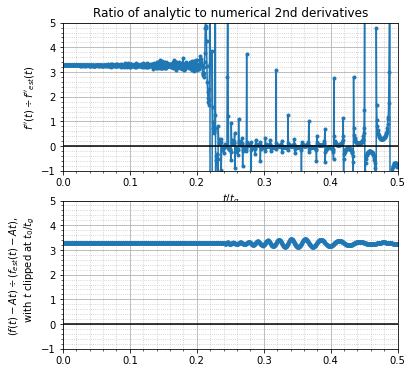

In [ ]:
#@title Simple derivative ratio plot vs time

display(IPython.display.Math("\\\\".join([f"A={A:0.3f}", f"B={B:0.3f}", f"X={X:0.3f}", f"Y={Y:0.3f}"]) ))

with np.printoptions(precision=1, suppress=True):
    analy2 = get_nth_gradient (inverted_values_analy[0], plot_times_tg, 2)
    numer2 = get_nth_gradient (inverted_values_numer[0], plot_times_tg, 2)
    print( analy2[0:100:10] )
    print( numer2[0:100:10] )
    print( (analy2/numer2)[0:100:10] )
with np.printoptions(precision=3, suppress=True):
    #print( ( (inverted_values_analy[0]-A*plot_times_tg)/(inverted_values_numer[0]-A*plot_times_tg))[0:-1:100] )
    #print( ( (inverted_values_analy[0]-A*t0_tg)/(inverted_values_numer[0]-A*t0_tg))[0:-1:100] )
    ratio_of_subtracted = (inverted_values_analy[0]-A*np.clip(plot_times_tg,0,t0_tg))/(inverted_values_numer[0]-A*np.clip(plot_times_tg,0,t0_tg))
    print( ratio_of_subtracted[0:-1:100] )



fig=plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.plot(plot_times_tg, analy2/numer2,".-")
plt.xlabel("$t/t_g$")
plt.ylabel(r"$f''(t) \div f''_{est}(t)$")
plt.title("Ratio of analytic to numerical 2nd derivatives")

plt.subplot(2,1,2)
plt.plot(plot_times_tg, ratio_of_subtracted,".-")
plt.ylabel(
    r"""$(f(t)-At) \div (f_{est}(t)-At)$, 
    with $t$ clipped at $t_0/t_g$""")


for ax in fig.axes:
    ax.grid(which="major")  # set major grid lines
    ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax.plot([plot_times_tg[0], plot_times_tg[-1] ], [0, 0],"k")
    ax.set_xlim([0,np.max(plot_times_tg)])
    ax.set_ylim([-1,5])

## Finding the effect of parameters on K, the correction factor (aka derivative ratio)

In [ ]:
#@title def plot_cohen_effect(...)
def plot_cohen_effect(param_name, param_vals, show_legend=False):
    VPEs = [(getCohenModelModified(**{param_name:param_val}), f"$Cohen, {param_name}={np.round(param_val,2)}$") for param_val in param_vals]

    plot_times_tg = np.linspace(0.001, 0.5, num=11, endpoint=True)

    inverted_values_analy = []
    inverted_values_numer = []
    inverted_ratios = []
    for vpe, name in VPEs:
            t0_tg, tg, strain_rate, E1, E3, v21, v31 = vpe.get_predefined_constants()
            A = E3 * strain_rate * tg
            inverted_values_analy.append(  vpe.inverted_value(plot_times_tg*tg) )
            inverted_values_numer.append(  inverting.euler_inversion(vpe.laplace_value, plot_times_tg) )
            inverted_ratios.append( (inverted_values_analy[-1]-A*np.clip(plot_times_tg, 0, t0_tg)) / (inverted_values_numer[-1]-A*np.clip(plot_times_tg, 0, t0_tg)) )


    fig = plt.figure(figsize=(6,4))
    for ind, (vpe, name) in enumerate(VPEs):
            plt.plot(param_vals[ind]*np.ones_like(inverted_ratios[ind]), inverted_ratios[ind],".", label=name)

    for ax in fig.axes:
            ax.grid(which="major")  # set major grid lines
            ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
            ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
            ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
            #ax.plot([plot_times_tg[0], plot_times_tg[-1] ], [0, 0],"k")
            ax.set_xlim([0,np.max(param_vals)])
            ax.set_ylim([0,None])
            ax.set_xlabel(param_name)
            ax.set_ylabel(r"""$(f(t)-A\varepsilon(t)) \div (f_{est}(t)-A\varepsilon(t))$""")

    if show_legend:
        plt.legend(ncol=3)

    itemindex = np.abs(plot_times_tg - t0_tg).argmin()
    for ind, (vpe, label) in enumerate(VPEs):
            pass
            #display(vpe.get_var_df())
            #display(vpe.alpha2_vals)
    df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
    #display(df_params)
    return fig, df_params, inverted_values_analy, inverted_values_numer

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,t0_tg,tg,strain_rate,E1,E3,v21,v31,Δ1,Δ2,Δ3,C11,C12,C13,C33,C0,C1,C2
CohenModelModified2 - Line #1,0.246184,40.62,0.01,1.000000,19,0.75,0.24,0.243937,0.569696,2.066384,2.335425,1.763997,0.983861,19.472253,0.244679,68.439846,82.356281
CohenModelModified2 - Line #21,0.246184,40.62,0.01,4.838384,19,0.75,0.24,0.220664,0.563047,2.257657,12.345628,9.580837,5.262351,21.525929,0.223949,15.888695,32.895367
CohenModelModified2 - Line #41,0.246184,40.62,0.01,8.676768,19,0.75,0.24,0.197391,0.556398,2.494033,24.457664,19.499511,10.549722,24.063867,0.202724,10.061412,31.314713
CohenModelModified2 - Line #61,0.246184,40.62,0.01,12.515152,19,0.75,0.24,0.174119,0.549748,2.793596,39.514328,32.362813,17.250514,27.280247,0.180985,8.031246,35.345677
CohenModelModified2 - Line #81,0.246184,40.62,0.01,16.353535,19,0.75,0.24,0.150846,0.543099,3.185594,58.878525,49.533648,26.018921,31.489082,0.158715,7.203375,43.596183


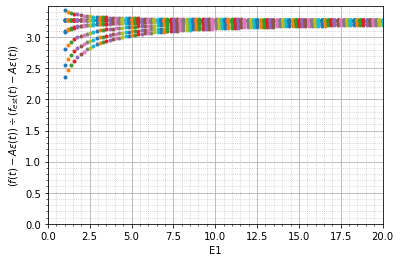

In [ ]:
#@title $E_1$
param_name = "E1"
param_vals = np.linspace(1,20,100,endpoint=True)
fig, df_params,_,_ = plot_cohen_effect(param_name,param_vals);
display(df_params.iloc[::20, :])  # show every xth row

<IPython.core.display.Javascript object>

,t0_tg,tg,strain_rate,E1,E3,v21,v31,Δ1,Δ2,Δ3,C11,C12,C13,C33,C0,C1,C2
CohenModelModified2 - Line #1,0.246184,40.62,0.01,8.5,1.0,0.75,0.24,-0.729200,0.291657,-0.353892,-3.399734,-8.256876,-2.797586,-0.342841,-1.428683,-0.237166,1.320196
CohenModelModified2 - Line #26,0.246184,40.62,0.01,8.5,7.0,0.75,0.24,0.110114,0.531461,4.270444,41.024835,36.167692,18.526207,15.892579,0.118395,7.179706,75.475735
CohenModelModified2 - Line #51,0.246184,40.62,0.01,8.5,13.0,0.75,0.24,0.174677,0.549908,2.785476,26.759204,21.902061,11.678704,18.605778,0.181513,8.061942,35.202060
CohenModelModified2 - Line #76,0.246184,40.62,0.01,8.5,19.0,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified2 - Line #101,0.246184,40.62,0.01,8.5,25.0,0.75,0.24,0.210832,0.560238,2.351153,22.586802,17.729659,9.675951,29.644456,0.215043,12.538559,31.168425


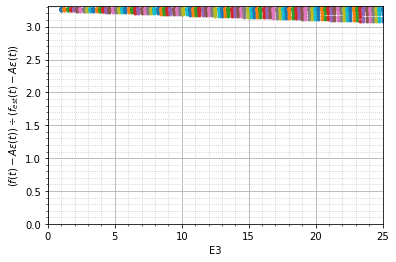

In [ ]:
#@title $E_3$
param_name = "E3"
param_vals = np.linspace(1,25,101,endpoint=True)
fig, df_params,_,_ =plot_cohen_effect(param_name,param_vals);
display(df_params.iloc[::25, :])  # show every xth row

<IPython.core.display.Javascript object>

,t0_tg,tg,strain_rate,E1,E3,v21,v31,Δ1,Δ2,Δ3,C11,C12,C13,C33,C0,C1,C2
CohenModelModified2 - Line #1,0.246184,1.0,0.01,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified2 - Line #21,0.246184,20.8,0.01,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified2 - Line #41,0.246184,40.6,0.01,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified2 - Line #61,0.246184,60.4,0.01,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified2 - Line #81,0.246184,80.2,0.01,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified2 - Line #101,0.246184,100.0,0.01,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221


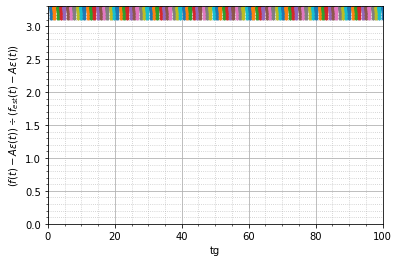

In [ ]:
#@title $t_g$
param_name = "tg"
param_vals = np.linspace(1,100,101,endpoint=True)
fig, df_params,_,_ = plot_cohen_effect(param_name,param_vals);
display(df_params.iloc[::20, :])  # show every xth row

<IPython.core.display.Javascript object>

,t0_tg,tg,strain_rate,E1,E3,v21,v31,Δ1,Δ2,Δ3,C11,C12,C13,C33,C0,C1,C2
CohenModelModified2 - Line #1,0.020,40.62,0.01,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified2 - Line #21,0.416,40.62,0.01,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified2 - Line #41,0.812,40.62,0.01,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified2 - Line #61,1.208,40.62,0.01,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified2 - Line #81,1.604,40.62,0.01,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified2 - Line #101,2.000,40.62,0.01,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221


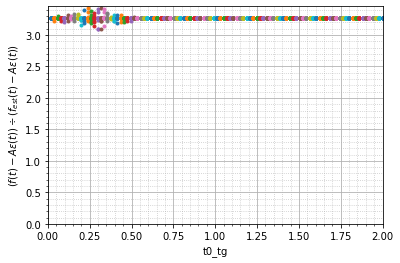

In [ ]:
#@title $t_0/t_g$
param_name = "t0_tg"
param_vals = np.linspace(0.02,2,101,endpoint=True)
fig, df_params,_,_ = plot_cohen_effect(param_name,param_vals);
display(df_params.iloc[::20, :])  # show every xth row

<IPython.core.display.Javascript object>

,t0_tg,tg,strain_rate,E1,E3,v21,v31,Δ1,Δ2,Δ3,C11,C12,C13,C33,C0,C1,C2
CohenModelModified2 - Line #1,0.246184,40.62,0.0010,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified2 - Line #21,0.246184,40.62,0.0208,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified2 - Line #41,0.246184,40.62,0.0406,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified2 - Line #61,0.246184,40.62,0.0604,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified2 - Line #81,0.246184,40.62,0.0802,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221
CohenModelModified2 - Line #101,0.246184,40.62,0.1000,8.5,19,0.75,0.24,0.198463,0.556704,2.481929,23.843125,18.985983,10.278986,23.933913,0.203713,10.207851,31.232221


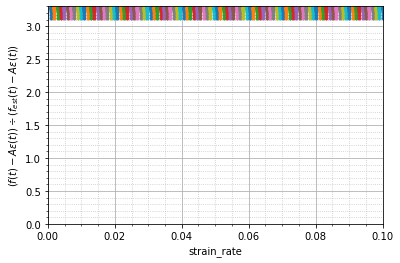

In [ ]:
#@title $\dot{\varepsilon}$, strain rate
param_name = "strain_rate"
param_vals = np.linspace(0.001,0.1,101,endpoint=True)
fig, df_params,_,_ = plot_cohen_effect(param_name,param_vals);
display(df_params.iloc[::20, :])  # show every xth row

<IPython.core.display.Javascript object>

,t0_tg,tg,strain_rate,E1,E3,v21,v31,Δ1,Δ2,Δ3,C11,C12,C13,C33,C0,C1,C2
CohenModelModified2 - Line #1,0.246184,40.62,0.01,8.5,19,0.100000,0.24,0.848463,0.885665,0.923595,8.872693,1.145420,2.404347,20.154087,0.870905,5.268210,5.722702
CohenModelModified2 - Line #11,0.246184,40.62,0.01,8.5,19,0.283673,0.24,0.664790,0.758940,1.010110,9.703810,3.082188,3.068640,20.472947,0.682373,6.260904,7.269105
CohenModelModified2 - Line #21,0.246184,40.62,0.01,8.5,19,0.467347,0.24,0.481116,0.663941,1.221025,11.730008,5.937241,4.240140,21.035267,0.493842,7.384592,9.899790
CohenModelModified2 - Line #31,0.246184,40.62,0.01,8.5,19,0.651020,0.24,0.297443,0.590078,1.755301,16.862630,11.714298,6.858463,22.292062,0.305310,8.881946,17.213093
CohenModelModified2 - Line #41,0.246184,40.62,0.01,8.5,19,0.834694,0.24,0.113769,0.531005,4.129702,39.672768,35.039843,17.931027,27.606893,0.116778,12.562751,82.883565


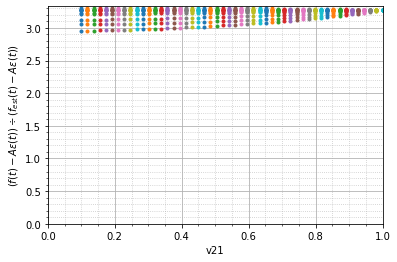

In [ ]:
#@title $\nu_{21}$
param_name = "v21"
param_vals = np.linspace(0.1,1,50,endpoint=True)
fig, df_params,_,_ = plot_cohen_effect(param_name,param_vals);
display(df_params.iloc[::10, :])  # show every xth row

<IPython.core.display.Javascript object>

,t0_tg,tg,strain_rate,E1,E3,v21,v31,Δ1,Δ2,Δ3,C11,C12,C13,C33,C0,C1,C2
CohenModelModified2 - Line #1,0.246184,40.62,0.01,8.5,19,0.75,0.01,0.249911,0.571403,2.285973,19.434658,14.577515,0.340122,19.006802,0.249922,14.548736,61.642039
CohenModelModified2 - Line #11,0.246184,40.62,0.01,8.5,19,0.75,0.11,0.239174,0.568335,2.318740,20.198085,15.340942,3.909293,19.860044,0.240475,12.275106,44.846663
CohenModelModified2 - Line #21,0.246184,40.62,0.01,8.5,19,0.75,0.21,0.210542,0.560155,2.425877,22.614557,17.757415,8.478114,22.560808,0.214779,10.619645,33.860610
CohenModelModified2 - Line #31,0.246184,40.62,0.01,8.5,19,0.75,0.31,0.164016,0.546862,2.693368,28.340711,23.483568,16.065526,28.960626,0.171384,9.364235,25.803105
CohenModelModified2 - Line #41,0.246184,40.62,0.01,8.5,19,0.75,0.41,0.099595,0.528456,3.522163,45.101509,40.244366,34.991809,47.693283,0.107694,8.392837,18.396253
CohenModelModified2 - Line #51,0.246184,40.62,0.01,8.5,19,0.75,0.51,0.017279,0.504937,14.021033,248.392629,243.535486,250.883338,274.901005,0.019554,7.864041,11.967041
CohenModelModified2 - Line #61,0.246184,40.62,0.01,8.5,19,0.75,0.61,-0.082932,0.476305,-1.469149,-48.818493,-53.675636,-62.521419,-57.276131,-0.099494,6.802206,28.353908
CohenModelModified2 - Line #71,0.246184,40.62,0.01,8.5,19,0.75,0.71,-0.201037,0.442561,0.018051,-18.711832,-23.568975,-30.019373,-23.627510,-0.259576,6.287990,19.654664
CohenModelModified2 - Line #81,0.246184,40.62,0.01,8.5,19,0.75,0.81,-0.337037,0.403704,0.373954,-10.181326,-15.038469,-20.428034,-14.093415,-0.477064,5.827605,16.191064
CohenModelModified2 - Line #91,0.246184,40.62,0.01,8.5,19,0.75,0.91,-0.490932,0.359734,0.480836,-6.228439,-11.085582,-15.755760,-9.675483,-0.779833,5.426658,13.970670


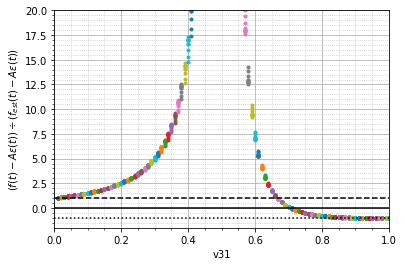

In [ ]:
#@title $\nu_{31}$
param_name = "v31"
param_vals = np.linspace(0.01,1,100,endpoint=True)
fig, df_params, inverted_values_analy, inverted_values_numer = plot_cohen_effect(param_name,param_vals);
fig.axes[0].set_ylim([-2,20])
fig.axes[0].plot([0,np.max(param_vals)],[0,0],"k")
fig.axes[0].plot([0,np.max(param_vals)],[1,1],"k--");
fig.axes[0].plot([0,np.max(param_vals)],[-1,-1],"k:");
display(df_params.iloc[::10, :])  # show every xth row

In [ ]:
#inverted_values_numer
inverted_values_analy_np=np.vstack(inverted_values_analy)
inverted_values_numer_np=np.vstack(inverted_values_numer)
(1-param_vals**2*E1/E3)

<IPython.core.display.Javascript object>

array([0.99995526, 0.99982105, 0.99959737, 0.99928421, 0.99888158,
       0.99838947, 0.99780789, 0.99713684, 0.99637632, 0.99552632,
       0.99458684, 0.99355789, 0.99243947, 0.99123158, 0.98993421,
       0.98854737, 0.98707105, 0.98550526, 0.98385   , 0.98210526,
       0.98027105, 0.97834737, 0.97633421, 0.97423158, 0.97203947,
       0.96975789, 0.96738684, 0.96492632, 0.96237632, 0.95973684,
       0.95700789, 0.95418947, 0.95128158, 0.94828421, 0.94519737,
       0.94202105, 0.93875526, 0.9354    , 0.93195526, 0.92842105,
       0.92479737, 0.92108421, 0.91728158, 0.91338947, 0.90940789,
       0.90533684, 0.90117632, 0.89692632, 0.89258684, 0.88815789,
       0.88363947, 0.87903158, 0.87433421, 0.86954737, 0.86467105,
       0.85970526, 0.85465   , 0.84950526, 0.84427105, 0.83894737,
       0.83353421, 0.82803158, 0.82243947, 0.81675789, 0.81098684,
       0.80512632, 0.79917632, 0.79313684, 0.78700789, 0.78078947,
       0.77448158, 0.76808421, 0.76159737, 0.75502105, 0.74835

### Searching for a equation that describes K

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide


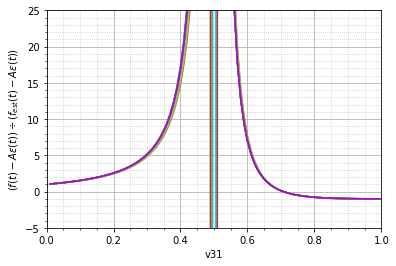

In [ ]:
#(1-2*v31)
#0.203713*10.207851/31.232221
#0.203713	10.207851	31.232221
#C0*C1/C2

VPEs = [(viscoporoelastic_model.CohenModel(), fr"$Cohen$") ]

t0_tg, tg, strain_rate, E1, E3, v21, v31 = VPEs[0][0].get_predefined_constants()
t0=t0_tg*tg
delta1, delta2, delta3, _, _, _, _, C0, C1, C2 = VPEs[0][0].get_calculable_constants()

1/(1-2*v31)
fig = plt.figure()
plt.plot(param_vals, ((inverted_values_analy_np-A*np.clip(plot_times_tg, 0, t0_tg))/(inverted_values_numer_np-A*np.clip(plot_times_tg, 0, t0_tg))) )
#plt.plot(param_vals, (1-2*param_vals) )
#plt.plot(param_vals, (1-v21-2*param_vals**2*E1/E3), "m")
#plt.plot(param_vals, (1-param_vals**2*E1/E3), "m")
#plt.plot(param_vals, (1-2*param_vals**2), "m")
plt.plot(param_vals, ((1-2*param_vals**2)/(1-2*param_vals)**2), "m")

#plt.ylim([-2,2])
plt.ylim([-5,25])
plt.xlim([0,1])

for ax in fig.axes:
        ax.grid(which="major")  # set major grid lines
        ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        #ax.plot([plot_times_tg[0], plot_times_tg[-1] ], [0, 0],"k")
        ax.set_xlim([0,np.max(param_vals)])
        ax.set_xlabel(param_name)
        ax.set_ylabel(r"""$(f(t)-A\varepsilon(t)) \div (f_{est}(t)-A\varepsilon(t))$""")

## Generalized Definition of correction factor, $K=\frac{1-2\nu_{31}^2}{(1-2\nu_{31})^2} $

Inversion (Time) Solution

$$
\large{
\begin{align}
f(t) =
\begin{cases}   
E_3 \dot{\varepsilon}_0 t   &+& K E_1 \dot{\varepsilon}_0 t_g \Delta_3 & \left( {\frac{1}{8} - \sum\limits_{\alpha_n^2}^{\infty} } \frac{\exp \left(-\frac{\alpha_n^2 t}{t_{g}}\right)}{\alpha_{n}^{2}\left(\Delta_2^2 \alpha_n^2-\frac{\Delta_1}{1+v_{21}}\right)}\right), & t \lt t_0 \\ 
E_3 \dot{\varepsilon}_0 t_0 &-& K E_1 \dot{\varepsilon}_0 t_g \Delta_3 & \left( \sum\limits_{\alpha_n^2}^{\infty} \frac{\exp{\left( -\frac{\alpha_n^2 t}{t_g} \right) } - \exp{\left(-\frac{\alpha_n^2\left(t-t_0\right)}{t_{g}} \right)}}{\alpha_{n}^{2}\left(\Delta_2^2 \alpha_n^2-\frac{\Delta_1}{1+v_{21}}\right)} \right), & t \geq t_0
\end{cases}
\end{align}}
$$




 $$ \text{Where } K=\frac{1-2\nu_{31}^2}{(1-2\nu_{31})^2} $$

Note that the correction factor K is not a simple function of $\Delta_1$, $\Delta_2$, or $\Delta_3$.

\begin{aligned}
\Delta_{1}&=1-v_{21}-2 v_{31}^{2} \frac{E_{1}}{E_{3}} \\
\Delta_{2}&=\left(1-v_{31}^{2} \frac{E_{1}}{E_{3}}\right) /\left(1+v_{21}\right) \\
\Delta_{3}&=\left(1-2 v_{31}^{2}\right) \frac{\Delta_{2}}{\Delta_{1}} \\
&= \left(1-2 v_{31}^{2}\right) \frac{\left(1-v_{31}^{2} \frac{E_{1}}{E_{3}}\right) /\left(1+v_{21}\right)}{1-v_{21}-2 v_{31}^{2} \frac{E_{1}}{E_{3}}}
=  \frac{\left(1-2 v_{31}^{2}\right) \left(1-v_{31}^{2} \frac{E_{1}}{E_{3}}\right) }{ \left( 1-v_{21}-2 v_{31}^{2} \frac{E_{1}}{E_{3}} \right) \left(1+v_{21}\right)}
\end{aligned}

### Find $\nu_{31}$ values to create key K values

 
$$
\begin{align}
\\
\text{Solve} \quad
 K=\frac{1-2\nu_{31}^2}{(1-2\nu_{31})^2} &= 1   \\
 \frac{1-2\nu_{31}^2}{1-4\nu_{31}+4\nu_{31}^2} &= 1 \\
1-4\nu_{31}+4\nu_{31}^2 &= 1-2\nu_{31}^2  \\
4\nu_{31}+6\nu_{31}^2 &= 0\\
2\nu_{31}\left(2+3\nu_{31}\right) &= 0\\
\text{Thus,} \quad 
 \nu_{31} &\in \left\{ 0, -\frac{2}{3} \right\} &&\xrightarrow{}& K&=1 \\
& &&\xrightarrow{}&  f_{\text{anl}}(t) & = f_{\text{est}}(t) & \\
\rule{5cm}{1pt} & \rule{3cm}{1pt} &&& \rule{1cm}{1pt} & \rule{1cm}{1pt}\\
 \\
\text{Solve} \quad
K=\frac{1-2\nu_{31}^2}{(1-2\nu_{31})^2} &= 0  \\
1-2\nu_{31}^2 &= 0\\
\nu_{31}^2&=1/2 \\
\nu_{31} &= \pm \sqrt{\frac{1}{2}} = \frac{\sqrt{2}}{2} \\
\text{Thus,} \quad 
 \nu_{31} &\approx \pm 0.707\dots & &\xrightarrow{}& K&= 0 \\
& &&\xrightarrow{}& f_{\text{anl}}(t) & \propto \dot{\varepsilon}(t) & \\
\rule{5cm}{1pt} & \rule{3cm}{1pt} &&& \rule{1cm}{1pt} & \rule{1cm}{1pt}\\
\\
\text{Solve} \quad
K=\frac{1-2\nu_{31}^2}{(1-2\nu_{31})^2} &= \text{undefined}   \\
(1-2\nu_{31})^2 &= 0 \\
\text{Thus,} \quad 
 \nu_{31} &= \frac{1}{2} & &\xrightarrow{}& K&= \text{undefined}& \\
& &&\xrightarrow{}& f_{\text{est}}(t) & \propto \dot{\varepsilon}(t) \text{ ?} & \\
\rule{5cm}{1pt} & \rule{3cm}{1pt} &&& \rule{1cm}{1pt} & \rule{1cm}{1pt}\\
\end{align}
$$
 
 

## Confirm K

In [ ]:
a, b = "a", "asd"
b

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'asd'

In [ ]:
importlib.reload(viscoporoelastic_model)

param_name, param_name_latex = "t0_tg", "t_{0}/t_{g}"   # Don't include the $ 
param_vals = np.linspace(0.1,1,5,endpoint=True)/2

#VPEs = [(CohenModel(), fr"$Cohen$"), (getCohenModelModified(E1=3), f"$Cohen, E1={3}$") ]
VPEs = [(getCohenModelModified(**{param_name:param_val}), f"For ${param_name_latex}={np.round(param_val,2)}$") for param_val in param_vals]

plot_times_tg, t_step = np.linspace(0.001, 0.5, num=1001, endpoint=True, retstep=True)
# plot_times and strain can't be defined until the loop values of t0_tg, tg, etc may be needed
inverted_values_analy_vals = [None] * len(VPEs)
inverted_values_numer_vals = [None] * len(VPEs)
inverted_values_numer_val_corrs = [None] * len(VPEs)
corrections = [None] * len(VPEs)

for ind, (vpe, name) in enumerate(VPEs):
    t0_tg, tg, strain_rate, E1, E3, v21, v31 = vpe.get_predefined_constants()
    t0=t0_tg*tg
    delta1, delta2, delta3, _, _, _, _, C0, C1, C2 = vpe.get_calculable_constants()
    corrections[ind] = (1-2*v31**2)/(1-2*v31)**2
    A = E3 * strain_rate * tg
    strain_eps0 = np.clip(plot_times_tg,0,t0_tg)  # defined as eps(t)/eps0

    inverted_values_analy_vals[ind] = vpe.inverted_value(plot_times_tg*tg)  /(A*t0_tg)
    inverted_values_numer_vals[ind] = inverting.euler_inversion(vpe.laplace_value, plot_times_tg) /(A*t0_tg)
    inverted_values_numer_val_corrs[ind] = (strain_eps0/t0_tg + (inverted_values_numer_vals[ind] - strain_eps0/t0_tg) * corrections[ind]) 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

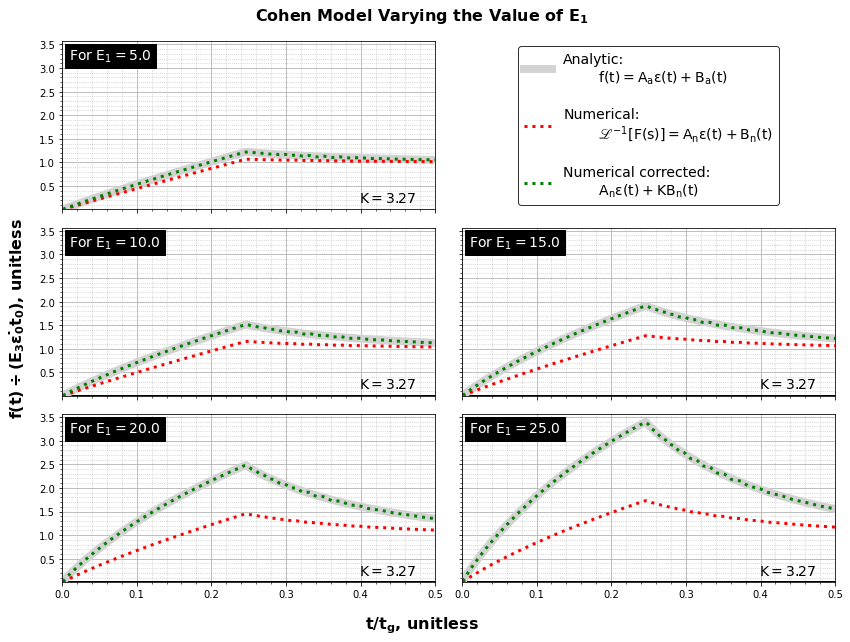

In [ ]:
param_name, param_name_latex = "t0_tg", r"t_{0}/t_{g}"   # Don't include the $ 
param_vals = np.linspace(0.05,0.5,5,endpoint=True)

param_name, param_name_latex = "v31", r"\nu_{31}"   # Don't include the $ 
param_vals = np.linspace(0.05,0.85,5,endpoint=True)

param_name, param_name_latex = "v21", r"\nu_{21}"   # Don't include the $ 
param_vals = np.linspace(0.05,0.85,5,endpoint=True)

param_name, param_name_latex = "E1", r"E_{1}"   # Don't include the $ 
param_vals = np.linspace(5,25,5,endpoint=True)

#param_name, param_name_latex = "E3", r"E_{3}"   # Don't include the $ 
#param_vals = np.linspace(5,25,5,endpoint=True)

#VPEs = [(CohenModel(), fr"$Cohen$"), (getCohenModelModified(E1=3), f"$Cohen, E1={3}$") ]
VPEs = [(getCohenModelModified(**{param_name:param_val}), f"For ${param_name_latex}={np.round(param_val,2)}$") for param_val in param_vals]

plot_times_tg, t_step = np.linspace(0.001, 0.5, num=1001, endpoint=True, retstep=True)
# plot_times and strain can't be defined until the loop values of t0_tg, tg, etc may be needed
inverted_values_analy_vals = [None] * len(VPEs)
inverted_values_numer_vals = [None] * len(VPEs)
inverted_values_numer_val_corrs = [None] * len(VPEs)
corrections = [None] * len(VPEs)

for ind, (vpe, name) in enumerate(VPEs):
    t0_tg, tg, strain_rate, E1, E3, v21, v31 = vpe.get_predefined_constants()
    t0=t0_tg*tg
    delta1, delta2, delta3, _, _, _, _, C0, C1, C2 = vpe.get_calculable_constants()
    corrections[ind] = (1-2*v31**2)/(1-2*v31)**2
    A = E3 * strain_rate * tg
    strain_eps0 = np.clip(plot_times_tg,0,t0_tg)  # defined as eps(t)/eps0

    inverted_values_analy_vals[ind] = vpe.inverted_value(plot_times_tg*tg)  /(A*t0_tg)
    inverted_values_numer_vals[ind] = inverting.euler_inversion(vpe.laplace_value, plot_times_tg) /(A*t0_tg)
    inverted_values_numer_val_corrs[ind] = (strain_eps0/t0_tg + (inverted_values_numer_vals[ind] - strain_eps0/t0_tg) * corrections[ind]) 


plt.rcParams['mathtext.default'] = 'regular'

ncols = np.floor(np.sqrt(len(VPEs))).astype(int)
nrows = np.ceil(len(VPEs)/ncols).astype(int)
nremainder = ncols*nrows-len(VPEs)
fig, axs = plt.subplots(nrows=nrows,ncols=ncols, figsize=(ncols*6,nrows*3), sharex=True, sharey=True)

#for ind, (vpe, name) in enumerate(VPEs):
nremainders_used = []
for ind2, ax in enumerate(axs.flat):
    if nremainder > len(nremainders_used):
        # Make extra blank subplots in the top/right so that there aren't any 
        # missing axes for the shared axes (since only one axes per column/row is 
        # shown, so there should definitely be a presented subplot in the left 
        # column and bottom row)
        if (ind2+1) % ncols == 0:
            nremainders_used.append(ind2)
            continue
    ind = ind2 - len(nremainders_used)
    vpe, name = VPEs[ind]
    axs.flat[ind2].plot(plot_times_tg, np.zeros_like(plot_times_tg),"k-",lw=2)
    axs.flat[ind2].plot(plot_times_tg, inverted_values_analy_vals[ind], "-", color="lightgray", lw=8, label=r"analy $f(t)=A_a\varepsilon(t)+B_a(t)$" )
    axs.flat[ind2].plot(plot_times_tg, inverted_values_numer_vals[ind], "r:", lw=3, label=r"numer $\mathscr{L}^{-1}(F(s))=A_n\varepsilon(t)+B_n(t)$" )
    axs.flat[ind2].plot(plot_times_tg, inverted_values_numer_val_corrs[ind], "g:", lw=3, label=r"Numerical corrected, $A_n\varepsilon(t)+KB_n(t)$" )
    #axs.flat[ind2].set_title(name)
    text = ax.text(0.02,0.96, name,
                    ha="left", va="top", color="w", 
                    bbox=dict(facecolor='k', alpha=1.0),
                    transform=ax.transAxes, fontsize=14
                    )
    """text = ax.text(0.01,0.96, name,
                    ha="left", va="top", color="k", 
                    #bbox=dict(facecolor='w', edgecolor="w", alpha=1.0),
                    transform=ax.transAxes, fontsize=14
                    )"""
    text = ax.text( np.max(plot_times_tg)*0.95, 0.1,f"$K={np.round(corrections[ind],2)}$",
                    ha="right", va="bottom", color="k", 
                    #bbox=dict(facecolor='w', alpha=1.0),
                    #transform=ax.transAxes, 
                    fontsize=14
                    )
    #axs.flat[ind2].set_title(name + f",\t $K={np.round(corrections[ind],2)}$")


handles, labels = axs.flat[0].get_legend_handles_labels()
labels = [r"Analytic, $f(t)=A_a\varepsilon(t)+B_a(t)$", r"Numerical, $\mathscr{L}^{-1}\left[F(s)\right]=A_n\varepsilon(t)+B_n(t)$", r"Numerical corrected, $A_n\varepsilon(t)+KB_n(t)$" ]
labels = [ 
          #("\n" if ind>0 else "")+
          ":\n\t".join(label.split(", ")) for ind, label in enumerate(labels)]

for ind2, ax in enumerate(axs.flat):

    if ind2 in nremainders_used:
        ax.set_axis_off()
        if ind2 == nremainders_used[0]:
            # put single legend in empty subplot
            ax.legend(handles, labels, loc="center", edgecolor="k", labelspacing=1.5, 
                      prop={
                          #'weight':'bold',
                          "size":14,
                          })  # 

    else:
        ax.grid(which="major")  # set major grid lines
        ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ax.set_xlim([0,np.max(plot_times_tg)])
        min_val = np.min(np.array(inverted_values_analy_vals))
        ax.set_ylim([min_val, None])
        #ax.set_xlabel("$t/t_g$, unitless")
        #ax.set_ylabel(r"$f(t) \div (E_3\dot{\varepsilon_0}t_0)$, unitless")
        #ax.legend()
        
if nremainder == 0:
    # put single legend attached to the overall figure
    fig.legend(handles, labels, weight="bold")
fig.supxlabel("$t/t_g$, unitless", fontsize=16, weight="bold")
fig.supylabel(r"$f(t) \div (E_3\dot{\varepsilon_0}t_0)$,"+" unitless\n", fontsize=16, weight="bold")
#fig.supylabel(r"$\frac{  f(t) }{E_3\dot{\varepsilon_0}t_0}$, unitless", fontsize=16)
fig.suptitle(f"Cohen Model Varying the Value of ${param_name_latex}$", fontsize=16, weight="bold")

plt.tight_layout()
plt.savefig(get_path_to_save(save_filename=f"Varying {param_name}", save_in_subfolder="Correction across varying params"), bbox_inches='tight')  # Include the bbox_inches='tight' is critical to ensure the saved images aren't cutoff while the colab images are normal

## Plot Cohen model with other strain input - TBD

In [ ]:
VPEs = [(viscoporoelastic_model.CohenModel(), fr"$Cohen$") ]

VPEs

fig = plt.figure()
plt.plot(param_vals, ((inverted_values_analy_np-A*np.clip(plot_times_tg, 0, t0_tg))/(inverted_values_numer_np-A*np.clip(plot_times_tg, 0, t0_tg))) )
#plt.plot(param_vals, (1-2*param_vals) )
#plt.plot(param_vals, (1-v21-2*param_vals**2*E1/E3), "m")
#plt.plot(param_vals, (1-param_vals**2*E1/E3), "m")
#plt.plot(param_vals, (1-2*param_vals**2), "m")
plt.plot(param_vals, ((1-2*param_vals**2)/(1-2*param_vals)**2), "m")

#plt.ylim([-2,2])
plt.ylim([-5,25])
plt.xlim([0,1])

for ax in fig.axes:
        ax.grid(which="major")  # set major grid lines
        ax.grid(which="minor", alpha=0.75, linestyle=":")  # set minor grid lines, but make them less visible
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        #ax.plot([plot_times_tg[0], plot_times_tg[-1] ], [0, 0],"k")
        ax.set_xlim([0,np.max(param_vals)])
        ax.set_xlabel(param_name)
        ax.set_ylabel(r"""$(f(t)-A\varepsilon(t)) \div (f_{est}(t)-A\varepsilon(t))$""")

<IPython.core.display.Javascript object>

[1]

In [ ]:
#@markdown Simple Laplace - Numerical Inversion

importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
times=np.arange(0.1,100,0.1)/10000.0*10
times=np.arange(0.1,100,0.1)/100.0*10

input_times = times
plot_times  = times
input_times_anal = input_times
plot_times_anal = plot_times/1  #tg=1


# \rm gives roman style letters, which is indicative of a constant
#@markdown $$ F(s)=\frac{1}{s-a} $$
#@markdown $$ f(t)={\mathrm{e}}^{a t}=\exp{\left(a t\right)} $$.
a = -3.03 #@param {type:"number"}
funcs = lambda s: 1/(s-a)
inv_funcs_anal = lambda t: np.exp(a*t)
plot_props = {
    "t":        {"y":{"name":r"f(t)"}, "x":{"name":r"t, unitless", "scale":"linear"}},
    "s":        {"y":{"name":r"$\overline{F}(s)$"},  "x":{"name":r"$s$, unitless"}, 
                 "eqn":{"text":r"$F(s)=\frac{1}{s-a}$, $a="+str(a)+r"$"}},
    "t_anal":   {"eqn":{"text":r"$f(t)={\mathrm{e}}^{a t}$, $a="+str(a)+r"$"}},
}
input_s = np.arange(0.05, 5.05, 0.05)


_=plotting.plot_laplace_analysis(funcs=funcs, plot_props=plot_props, input_s=input_s, 
                                 input_times=input_times, plot_times=plot_times, time_const=1, 
                                 input_times_anal=input_times_anal, plot_times_anal=plot_times_anal, inv_funcs_anal=inv_funcs_anal,
                                 plot_mode="simple")


# Viscoporoelastic Models Inversions

\begin{aligned}
\Delta_{1}&=1-v_{21}-2 v_{31}^{2} \frac{E_{1}}{E_{3}} \\
\Delta_{2}&=\left(1-v_{31}^{2} \frac{E_{1}}{E_{3}}\right) /\left(1+v_{21}\right) \\
\Delta_{3}&=\left(1-2 v_{31}^{2}\right) \frac{\Delta_{2}}{\Delta_{1}} \\
&= \left(1-2 v_{31}^{2}\right) \frac{\left(1-v_{31}^{2} \frac{E_{1}}{E_{3}}\right) /\left(1+v_{21}\right)}{1-v_{21}-2 v_{31}^{2} \frac{E_{1}}{E_{3}}}
=  \frac{\left(1-2 v_{31}^{2}\right) \left(1-v_{31}^{2} \frac{E_{1}}{E_{3}}\right) }{ \left( 1-v_{21}-2 v_{31}^{2} \frac{E_{1}}{E_{3}} \right) \left(1+v_{21}\right)}
\end{aligned}

<IPython.core.display.Javascript object>

It took 0.0259 sec to evaluate the Laplace space func for 1097 input s vals.
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([0]),).
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([0]),).
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([0]),).
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([0]),).
Warning the function could not be inverted at some values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are (array([0]),).
It took 1.2219 sec to numerically invert Laplace the func for 1001 input times.


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,Value,Category
t0/tg,0.100,Constant
strain_rate,0.010,Constant
Vrz,0.240,Constant
Ezz,19.190,Constant
c,1.000,FittedParam
tau1,0.100,FittedParam
tau2,10.000,FittedParam
tg,40.620,FittedParam
Vrtheta,0.700,FittedParam
Err,8.490,FittedParam


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,Value,Category
t0/tg,0.100,Constant
strain_rate,0.010,Constant
Vrz,0.240,Constant
Ezz,19.190,Constant
c,1.000,FittedParam
tau1,0.100,FittedParam
tau2,10.000,FittedParam
tg,40.620,FittedParam
Vrtheta,0.725,FittedParam
Err,8.490,FittedParam


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,Value,Category
t0/tg,0.100,Constant
strain_rate,0.010,Constant
Vrz,0.240,Constant
Ezz,19.190,Constant
c,1.000,FittedParam
tau1,0.100,FittedParam
tau2,10.000,FittedParam
tg,40.620,FittedParam
Vrtheta,0.750,FittedParam
Err,8.490,FittedParam


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,Value,Category
t0/tg,0.100,Constant
strain_rate,0.010,Constant
Vrz,0.240,Constant
Ezz,19.190,Constant
c,1.000,FittedParam
tau1,0.100,FittedParam
tau2,10.000,FittedParam
tg,40.620,FittedParam
Vrtheta,0.775,FittedParam
Err,8.490,FittedParam


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,Value,Category
t0/tg,0.100,Constant
strain_rate,0.010,Constant
Vrz,0.240,Constant
Ezz,19.190,Constant
c,1.000,FittedParam
tau1,0.100,FittedParam
tau2,10.000,FittedParam
tg,40.620,FittedParam
Vrtheta,0.800,FittedParam
Err,8.490,FittedParam


,t0/tg,strain_rate,Vrz,Ezz,c,tau1,tau2,tg,Vrtheta,Err,t0
ViscoporoelasticModel1 - Line #1,0.1,0.01,0.24,19.19,1,0.1,10,40.62,0.700,8.49,4.062
ViscoporoelasticModel1 - Line #2,0.1,0.01,0.24,19.19,1,0.1,10,40.62,0.725,8.49,4.062
ViscoporoelasticModel1 - Line #3,0.1,0.01,0.24,19.19,1,0.1,10,40.62,0.750,8.49,4.062
ViscoporoelasticModel1 - Line #4,0.1,0.01,0.24,19.19,1,0.1,10,40.62,0.775,8.49,4.062
ViscoporoelasticModel1 - Line #5,0.1,0.01,0.24,19.19,1,0.1,10,40.62,0.800,8.49,4.062


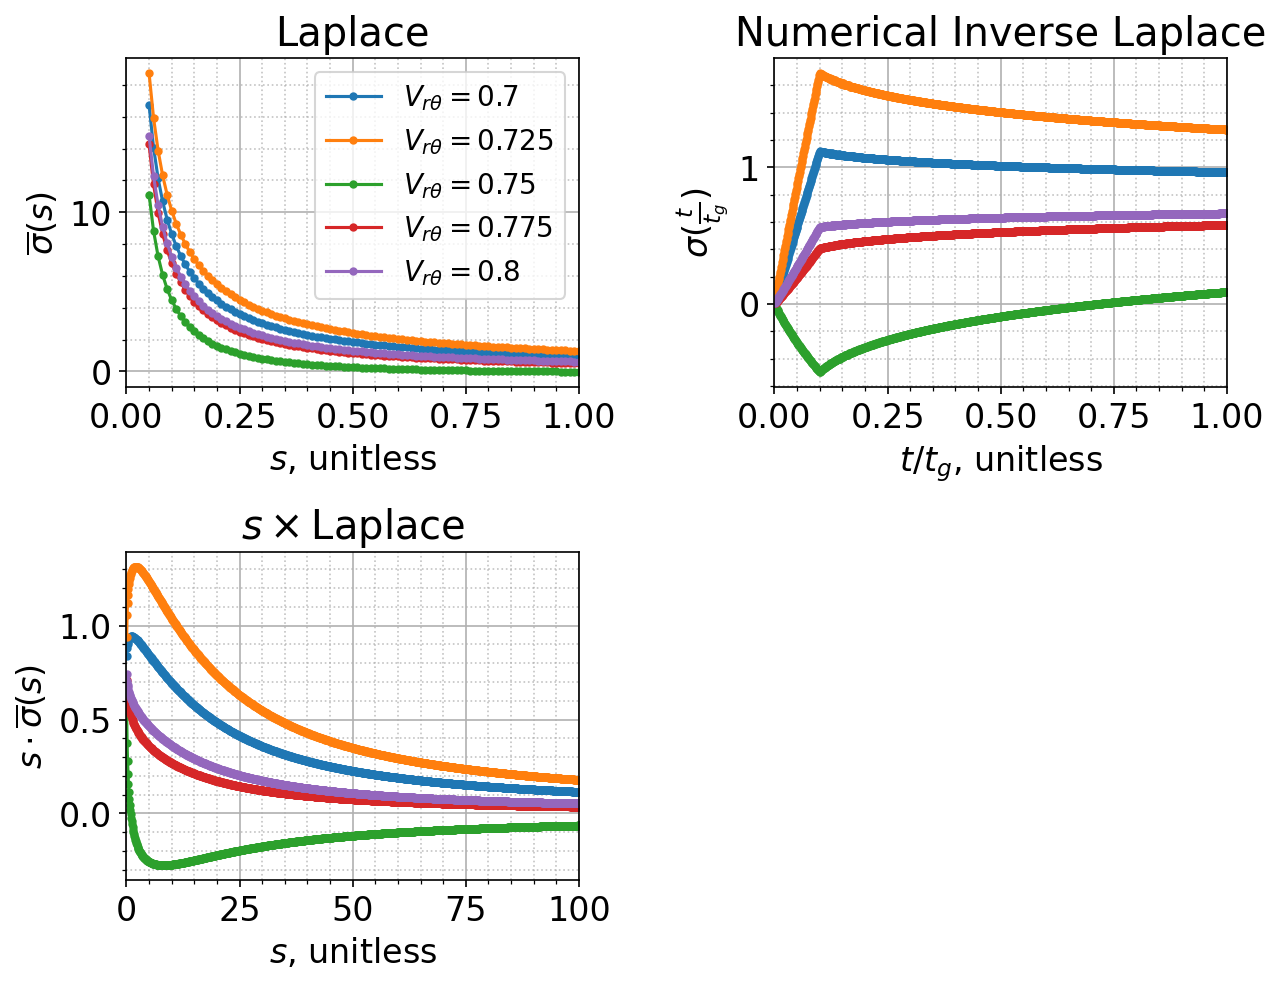

In [ ]:
#@title # ViscoporoelasticModel1


importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import ViscoporoelasticModel1

#warnings.simplefilter('error') # throws all warnings as errors
#%pdb off

#@markdown Predefined constants
ViscoporoelasticModel1.t0_tg = 0.1 #@param {type:"number"} ; # 10 percent
ViscoporoelasticModel1.strain_rate = 0.01 #@param {type:"number"} ; # 1 percent per s (normally 1#/s)
## Below are directly determined by the mesh deformation part of the
## experiment (see our paper with Daniel).  -Dr. Spector
ViscoporoelasticModel1.Vrz = 0.24 #@param {type:"number"} ; # Not actually v, but greek nu (represents Poisson's ratio)
ViscoporoelasticModel1.Ezz =   19.19 #@param {type:"number"} ; # Note- don't mix up Ezz with epszz

#@markdown Fitted parameters (to be determined by experimental fitting to the unknown material)
## Fitted parameters (to be determined by experimental fitting to
# the unknown material)
c =   1 #@param {type:"number"} ;
tau1 =  0.1 #@param {type:"number"} ;  # units = sec
tau2 =  10 #@param {type:"number"} ;  # units = sec
#tau = [tau1, tau2];
#tau = [1 1];
tg=40.62 #@param {type:"number"}; #in units of s   # for porosity_sp == 0.5
Vrtheta =  0.75 #@param {type:"number"}; # Not actually v, but greek nu (represents Poisson's ratio)
Err =  8.49 #@param {type:"number"};

VPEs = [(ViscoporoelasticModel1(c=c,
                               tau1=tau1,
                               tau2=tau2, 
                               tg=tg, 
                               Vrtheta=Vrtheta, 
                               Err=Err), fr"$V_{{r\theta}}={Vrtheta}$") 
                              for Vrtheta in [0.7, 0.725, 0.75, 0.775, 0.8]]

t0_tg = VPEs[0][0].t0_tg

"""
func = []
import copy
func.append(vpe.laplace_value)
vpeB = copy.deepcopy(vpe)
vpeB.Vrtheta =  0.7
func.append(vpeB.laplace_value)
"""

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
#plot_times = np.arange(0.01, 1.001, 0.001)*tg
plot_times = np.linspace(0.001, 1, num=1001, endpoint=True)*tg
#input_times = np.concatenate((plot_times, np.array([5,10,20])*tg))
input_times = plot_times
#func = vpe.laplace_value
func = [vpe.laplace_value for vpe, label in VPEs]
func_labels = [label for vpe, label in VPEs]
func_name = {"t":r"$\sigma(\frac{t}{t_g})$", "s":r"$\overline{\sigma}(s)$"}
x_names   = {"t":r"$t/t_g$, unitless", "s":r"$s$, unitless"}
plot_props = {
    "t":{"y":{"name":r"$\sigma(\frac{t}{t_g})$"}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
    "s":{"y":{"name":r"$\overline{\sigma}(s)$"},  "x":{"name":r"$s$, unitless"}},
}
plot_s = np.linspace(0.05, 1, num=96, endpoint=True)
plot_s_s = np.linspace(0.05, 100, num=1000, endpoint=True) # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s,
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    #model_name = VPEs[0][0].get_model_name(), 
    func_labels = func_labels)

itemindex = np.abs(input_times/tg - t0_tg).argmin()
for ind, ((vpe, label), laplace_vals, inverted_vals_numerical, inverted_vals_analytical) in enumerate(zip(VPEs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all)):
    display(IPython.display.Latex(fr"\text{{ \#{ind+1}) {vpe.get_model_name()} with }} {label.replace('$','')}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[itemindex]/tg:.3f}, \quad {func_name['t'].replace('$','')}={inverted_vals_numerical[itemindex]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[-1]/tg:.3f}, \quad {func_name['t'].replace('$','')}={inverted_vals_numerical[-1]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} s={input_s[0]:.3f}, \quad s\cdot{func_name['s'].replace('$','')}={laplace_vals[0]*input_s[0]:0.3f}"))
    display(vpe.get_var_df())

#df_params = pd.DataFrame(vpe.get_var_dict(),index=[vpe.get_model_name()])
#df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
#df_params = pd.DataFrame([{**vpe.get_var_dict(), **{"lab":label}} for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)


In [ ]:
#@title # ViscoporoelasticModel2
importlib.reload(plotting)
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import ViscoporoelasticModel2

VPEs = [(ViscoporoelasticModel2(t0_tg=t0_tg), fr"$t_0/t_g={t0_tg}$") 
                              for t0_tg in [1, 10]]
tg = VPEs[0][0].tg
t0_tg = VPEs[0][0].t0_tg

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
plot_times = np.linspace(0.01, 25, num=10001, endpoint=True)*tg
#plot_times = np.logspace(-3, 4, num=10001, endpoint=True)*tg
#input_times = plot_times
plot_times_log = np.logspace(-3, 3, num=10001, endpoint=True)*tg
input_times = np.concatenate((plot_times, plot_times_log))
func = [vpe.laplace_value for vpe, label in VPEs]
func_labels = [label for vpe, label in VPEs]
func_name = {"t":r"$T(\frac{t}{t_g})$", "s":r"$\overline{T}(s)$"}
x_names   = {"t":"$t/t_g$, unitless", "s":"$s$, unitless"}
plot_props = {
    "t":{"y":{"name":r"$T(\frac{t}{t_g})$"}, "x":{"name":"$t/t_g$, unitless", "scale":"linear"}},
    "s":{"y":{"name":r"$\overline{T}(s)$"},  "x":{"name":"$s$, unitless"}},
  }
plot_s = np.linspace(0.01, 0.4, num=1001, endpoint=True)
plot_s_s = np.linspace(1, 1000, num=1000, endpoint=True) # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))

plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s, 
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    #model_name = VPEs[0][0].get_model_name(), 
    func_labels = func_labels)
ax01 = axs[0,1] if isinstance(axs[1], collections.abc.Container) else axs[1]
ax11 = axs[1,1] if isinstance(axs[1], collections.abc.Container) else axs[1]


ax_curr=ax11
ax_curr.axis("on")
for inverted_vals_numerical, func_label in zip(inverted_vals_numerical_all, func_labels):
    ax_curr.plot(plot_times_log/tg, inverted_vals_numerical[-len(plot_times_log):], ".-", label=func_label)
ax_curr.set_xlabel(plot_props.get("t").get("x").get("name"))   # plot_props["t"]["x"]["name"] 
#ax_curr.set_xscale(plot_props.get("t").get("x").get("scale") or "linear")
ax_curr.set_xscale("log")
ax_curr.set_xlim( [min(plot_times_log/tg), max(plot_times_log/tg)]) 
ax_curr.set_ylabel(plot_props.get("t").get("y").get("name"))  # plot_props["t"]["y"]["name"]
ax_curr.set_yscale(plot_props.get("t").get("y").get("scale") or "linear")
ax_curr.title.set_text("Numerical Inverse Laplace")
ax_curr.grid(which="major")
ax_curr.grid(which="minor", alpha=0.75, linestyle=":")
ax_curr.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10,subs=np.arange(2,10),numticks=10*ax01.xaxis.get_tick_space()))
ax_curr.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())


df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[vpe.get_model_name() for vpe, label in VPEs])
display(df_params)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

It took 0.0089 sec to evaluate the Laplace space func for 1097 input s vals.
Warning the function could not be inverted at some (168/2002) values of t as the I1(sqrt(f)) component led to +/- infinity. The indices of these time points are 0-4,1001-1163. The values are [0.001      0.002999   0.004998   0.006997   0.008996   0.001
 0.00101391 0.00102802 0.00104232 0.00105682 0.00107152 0.00108643
 0.00110154 0.00111686 0.0011324  0.00114815 0.00116413 0.00118032
 0.00119674 0.00121339 0.00123027 0.00124738 0.00126474 0.00128233
 0.00130017 0.00131826 0.0013366  0.00135519 0.00137404 0.00139316
 0.00141254 0.00143219 0.00145211 0.00147231 0.00149279 0.00151356
 0.00153462 0.00155597 0.00157761 0.00159956 0.00162181 0.00164437
 0.00166725 0.00169044 0.00171396 0.0017378  0.00176198 0.00178649
 0.00181134 0.00183654 0.00186209 0.00188799 0.00191426 0.00194089
 0.00196789 0.00199526 0.00202302 0.00205116 0.0020797  0.00210863
 0.00213796 0.0021677  0.00219786 0.00222844 0.00225944 0.00229087


<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Latex object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

,t0/tg,strain_rate,Vrz,Ezz,c,tau1,tau2,tg,Vrtheta,Err,t0
ViscoporoelasticModel3 - Line #1,0.246184,0.01,0.24,19,0.0,0.1,10,40.62,0.75,8.49,10.0
ViscoporoelasticModel3 - Line #2,0.246184,0.01,0.24,19,0.5,0.1,10,40.62,0.75,8.49,10.0
ViscoporoelasticModel3 - Line #3,0.246184,0.01,0.24,19,1.0,0.1,10,40.62,0.75,8.49,10.0
ViscoporoelasticModel3 - Line #4,0.246184,0.01,0.24,19,2.0,0.1,10,40.62,0.75,8.49,10.0


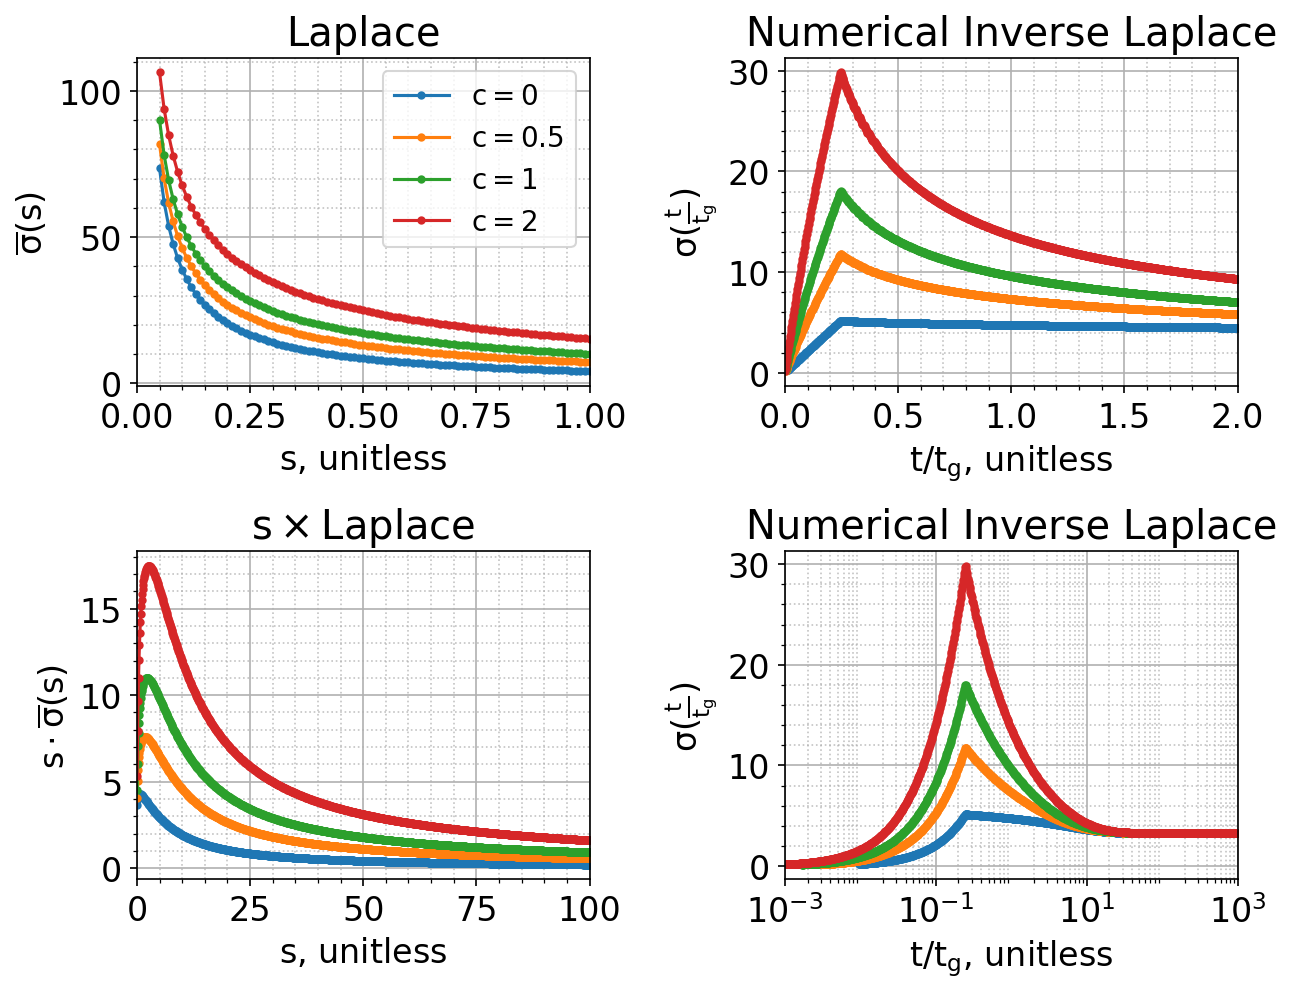

In [ ]:
#@title # ViscoporoelasticModel3
importlib.reload(plotting)
plotting.reload_imports()
importlib.reload(viscoporoelastic_model)
from viscoporoelastic_model import ViscoporoelasticModel3

ViscoporoelasticModel3.Ezz = 19  # kPa
ViscoporoelasticModel3.Vrz = 0.24  #unitless
ViscoporoelasticModel3.strain_rate = 0.01  # sec^-1

#@markdown Fitted parameters (to be determined by experimental fitting to the unknown material)
## Fitted parameters (to be determined by experimental fitting to
# the unknown material)
c =   1 #@param {type:"number"} ;
tau1 =  0.1 #@param {type:"number"} ;  # units = sec
tau2 =  10 #@param {type:"number"} ;  # units = sec
#tau = [tau1, tau2];
#tau = [1 1];
tg=40.62 #@param {type:"number"}; #in units of s   # for porosity_sp == 0.5
Vrtheta =  0.75 #@param {type:"number"}; # Not actually v, but greek nu (represents Poisson's ratio)
Err =  8.49 #@param {type:"number"};

VPEs = [(ViscoporoelasticModel3(c=c,
                               tau1=tau1,
                               tau2=tau2, 
                               tg=tg, 
                               Vrtheta=Vrtheta, 
                               Err=Err), fr"$c={c}$") 
                              for c in [0, 0.5, 1, 2]]

t0_tg = VPEs[0][0].t0_tg

"""
func = []
import copy
func.append(vpe.laplace_value)
vpeB = copy.deepcopy(vpe)
vpeB.Vrtheta =  0.7
func.append(vpeB.laplace_value)
"""

# inputting a value of time=0 doesn't error (just returns None/NaN), but takes longer (about 2x as much) on python; not really MATLAB though
#plot_times = np.arange(0.01, 1.001, 0.001)*tg
plot_times = np.linspace(0.001, 2, num=1001, endpoint=True)*tg
#input_times = np.concatenate((plot_times, np.array([5,10,20])*tg))
plot_times_log = np.logspace(-3, 3, num=1001, endpoint=True)*tg
input_times = np.concatenate((plot_times, plot_times_log))
#func = vpe.laplace_value
func = [vpe.laplace_value for vpe, label in VPEs]
func_labels = [label for vpe, label in VPEs]
func_name = {"t":r"$\sigma(\frac{t}{t_g})$", "s":r"$\overline{\sigma}(s)$"}
x_names   = {"t":r"$t/t_g$, unitless", "s":r"$s$, unitless"}
plot_props = {
    "t":{"y":{"name":r"$\sigma(\frac{t}{t_g})$"}, "x":{"name":r"$t/t_g$, unitless", "scale":"linear"}},
    "s":{"y":{"name":r"$\overline{\sigma}(s)$"},  "x":{"name":r"$s$, unitless"}},
}
plot_s = np.linspace(0.05, 1, num=96, endpoint=True)
plot_s_s = np.linspace(0.05, 100, num=1000, endpoint=True) # for function x s
input_s = np.concatenate((plot_s, plot_s_s, np.array([0.001])))


plt.rc('font', size=16)  # default font size is 10
fig, axs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all=plotting.plot_laplace_analysis(
    funcs=func, plot_props=plot_props, input_s=input_s, plot_s=plot_s, plot_s_s=plot_s_s,
    input_times=input_times, plot_times=plot_times, time_const=tg, 
    #model_name = VPEs[0][0].get_model_name(), 
    func_labels = func_labels)

ax01 = axs[0,1] if isinstance(axs[1], collections.abc.Container) else axs[1]
ax11 = axs[1,1] if isinstance(axs[1], collections.abc.Container) else axs[1]


ax_curr=ax11
ax_curr.axis("on")
for inverted_vals_numerical, func_label in zip(inverted_vals_numerical_all, func_labels):
    ax_curr.plot(plot_times_log/tg, inverted_vals_numerical[-len(plot_times_log):], ".-", label=func_label)
ax_curr.set_xlabel(plot_props.get("t").get("x").get("name"))   # plot_props["t"]["x"]["name"] 
#ax_curr.set_xscale(plot_props.get("t").get("x").get("scale") or "linear")
ax_curr.set_xscale("log")
ax_curr.set_xlim( [min(plot_times_log/tg), max(plot_times_log/tg)]) 
ax_curr.set_ylabel(plot_props.get("t").get("y").get("name"))  # plot_props["t"]["y"]["name"]
ax_curr.set_yscale(plot_props.get("t").get("y").get("scale") or "linear")
ax_curr.title.set_text("Numerical Inverse Laplace")
ax_curr.grid(which="major")
ax_curr.grid(which="minor", alpha=0.75, linestyle=":")
ax_curr.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10,subs=np.arange(2,10),numticks=10*ax01.xaxis.get_tick_space()))
ax_curr.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())


itemindex = np.abs(input_times/tg - t0_tg).argmin()
for ind, ((vpe, label), laplace_vals, inverted_vals_numerical, inverted_vals_analytical) in enumerate(zip(VPEs, laplace_vals_all, inverted_vals_numerical_all, inverted_vals_analytical_all)):
    display(IPython.display.Latex(fr"\text{{ \#{ind+1}) {vpe.get_model_name()} with }} {label.replace('$','')}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[itemindex]/tg:.3f}, \quad {func_name['t'].replace('$','')}={inverted_vals_numerical[itemindex]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} t/t_g={input_times[-1]/tg:.3f}, \quad {func_name['t'].replace('$','')}={inverted_vals_numerical[-1]:0.5f}"))
    display(IPython.display.Math(fr"\text{{At }} s={input_s[0]:.3f}, \quad s\cdot{func_name['s'].replace('$','')}={laplace_vals[0]*input_s[0]:0.3f}"))
    #display(vpe.get_var_df())


#df_params = pd.DataFrame(vpe.get_var_dict(),index=[vpe.get_model_name()])
#df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
#df_params = pd.DataFrame([{**vpe.get_var_dict(), **{"lab":label}} for vpe, label in VPEs], index=[vpe.get_model_name() + "-" + label for vpe, label in VPEs])
df_params = pd.DataFrame([vpe.get_var_dict() for vpe, label in VPEs], index=[f"{vpe.get_model_name()} - Line #{ind+1}" for ind, (vpe, label) in enumerate(VPEs)])
display(df_params)

# Laplace function relevant properties - for diagnosing errors
## Sources:
*   https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/LaplaceProps.html
*   https://lpsa.swarthmore.edu/LaplaceZTable/Common%20Laplace%20Transform%20Pairs.pdf

## Properties:  
1. Initial Value Theorem   
image.png

1. Final Value Theorem   
image.png

1. Time scaling.  
![image.png](https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/Funcs/imgB1.gif)

1. Multiplication by time.  
![image.png](https://lpsa.swarthmore.edu/LaplaceXform/FwdLaplace/Funcs/imgAF.gif)

$f'(t)$ represents the derivative of $f(t)$
$$
\begin{align}
\L{f'(t)}&=sF(s)-f(0^-) \\
\L{f''(t)}&=s^2F(s)-sf(0^-)-f'(0^-) \\ 
\L{f'''(t)}&=s^3F(s)-s^2f(0^-)-sf'(0^-)-f''(0^-) \\ 
\L{f^{(m)}(t)}&=s^mF(s)-\sum_{n=m-1}^{0} s^nf^{(m-n-1)}(0^-) \\ 
\end{align}
$$

$f'(t)$ represents the derivative of $f(t)$
$$
\begin{align}
\L{f'(t)}&=sF(s)-f(0^-) \\
\L{f''(t)}&=s^2F(s)-sf(0^-)-f'(0^-) \\ 
\L{f'''(t)}&=s^3F(s)-s^2f(0^-)-sf'(0^-)-f''(0^-) \\ 
\L{f^{(m)}(t)}&=s^mF(s)-\sum_{n=m-1}^{0} s^nf^{(m-n-1)}(0^-) \\ 
\end{align}
$$

#Bessel info
Source: wolfram alpha

image.png

image.png

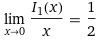

Source: https://www.mathworks.com/help/matlab/ref/besseli.html
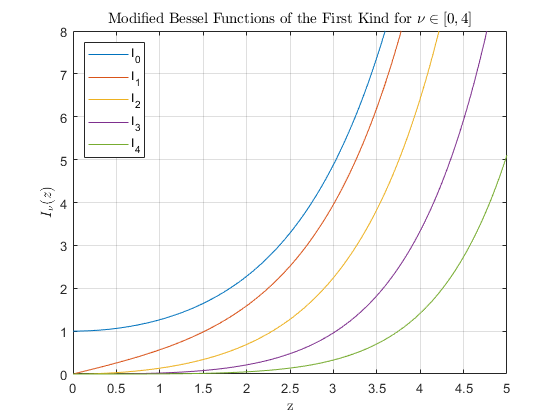

Misra, D.K. (2006). Appendix C: Bessel Functions. In Practical Electromagnetics, D.K. Misra (Ed.). https://doi-org.proxy2.library.illinois.edu/10.1002/9780470054208.app3

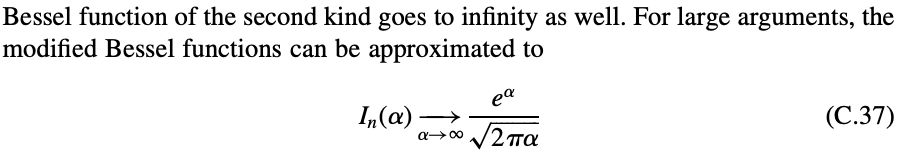


Zeros of Bessel’s Functions of the First Kind   

| # of Zeros |    J0(x) 	| J1(x)    	| J2(x)    	| J3(x)    	| J4(x)    	| J5(x)    	|
|-------------	|-----------------	|----------	|----------	|----------	|----------	|----------	|
|           1 	| 2.40483         	| 3.83171  	| 5.13562  	| 6.38016  	| 7.58834  	| 8.77148  	|
| 2           	| 5.52008         	| 7.01559  	| 8.41724  	| 9.76102  	| 11.06471 	| 12.3386  	|
| 3           	| 8.65373         	| 10.17347 	| 11.61984 	| 13.0152  	| 14.37254 	| 15.70017 	|
| 4           	| 11.79153        	| 13.32369 	| 14.79595 	| 16.22347 	| 17.61597 	| 18.98013 	|
| 5           	| 14.93092        	| 16.47063 	| 17.95982 	| 19.40941 	| 20.82693 	| 22.2178  	|

TABLE C.2 Zeros of the Derivatives of Bessel’s Functions of the First Kind

| Number of Zeros 	| J0'(x)   	| J1'(x)   	| J2'(x)   	| J3'(x)   	| J4'(x)   	| J5'(x)   	|
|-----------------	|----------	|----------	|----------	|----------	|----------	|----------	|
| 1               	| 3.83171  	| 1.84118  	| 3.05424  	| 4.20119  	| 5.31755  	| 6.41562  	|
| 2               	| 7.01559  	| 5.33144  	| 6.70613  	| 8.01524  	| 9.2824   	| 10.51986 	|
| 3               	| 10.17347 	| 8.53632  	| 9.96947  	| 11.34592 	| 12.68191 	| 13.98719 	|
| 4               	| 13.32369 	| 11.706   	| 13.17037 	| 14.58585 	| 15.96411 	| 17.31284 	|
| 5               	| 16.4706  	| 14.86359 	| 16.34752 	| 17.78875 	| 19.19603 	| 20.57551 	|

https://functions.wolfram.com/Bessel-TypeFunctions/BesselI/introductions/Bessels/ShowAll.html

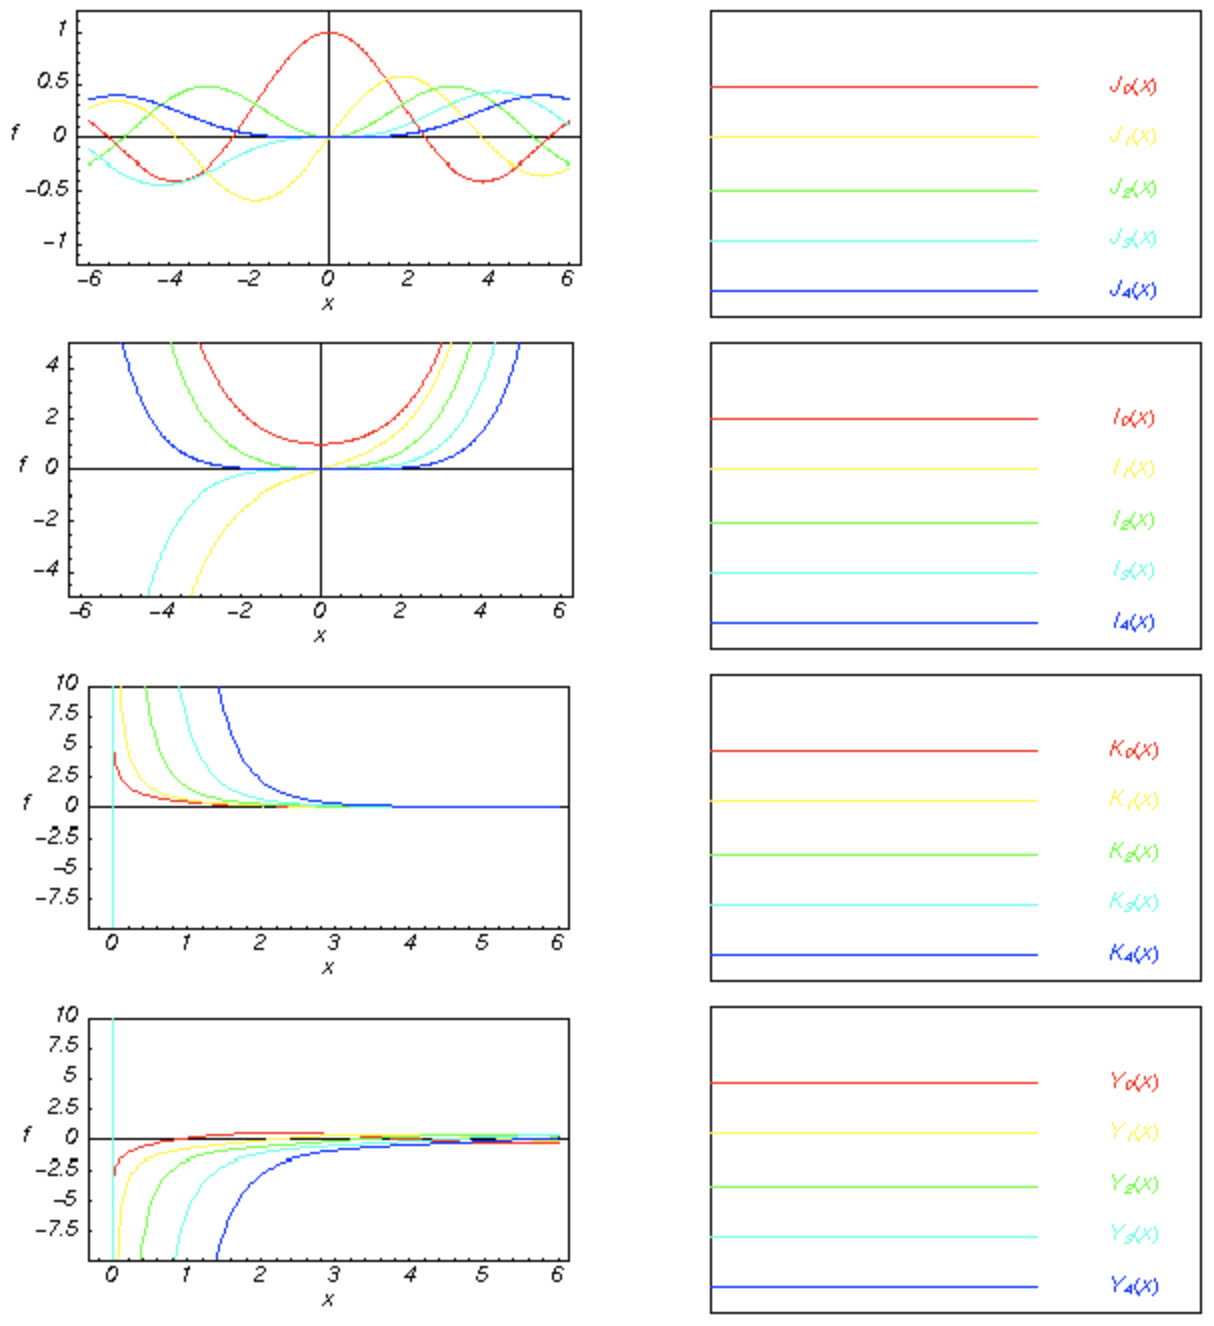

Source: http://www.mhtlab.uwaterloo.ca/courses/me755/web_chap4.pdf
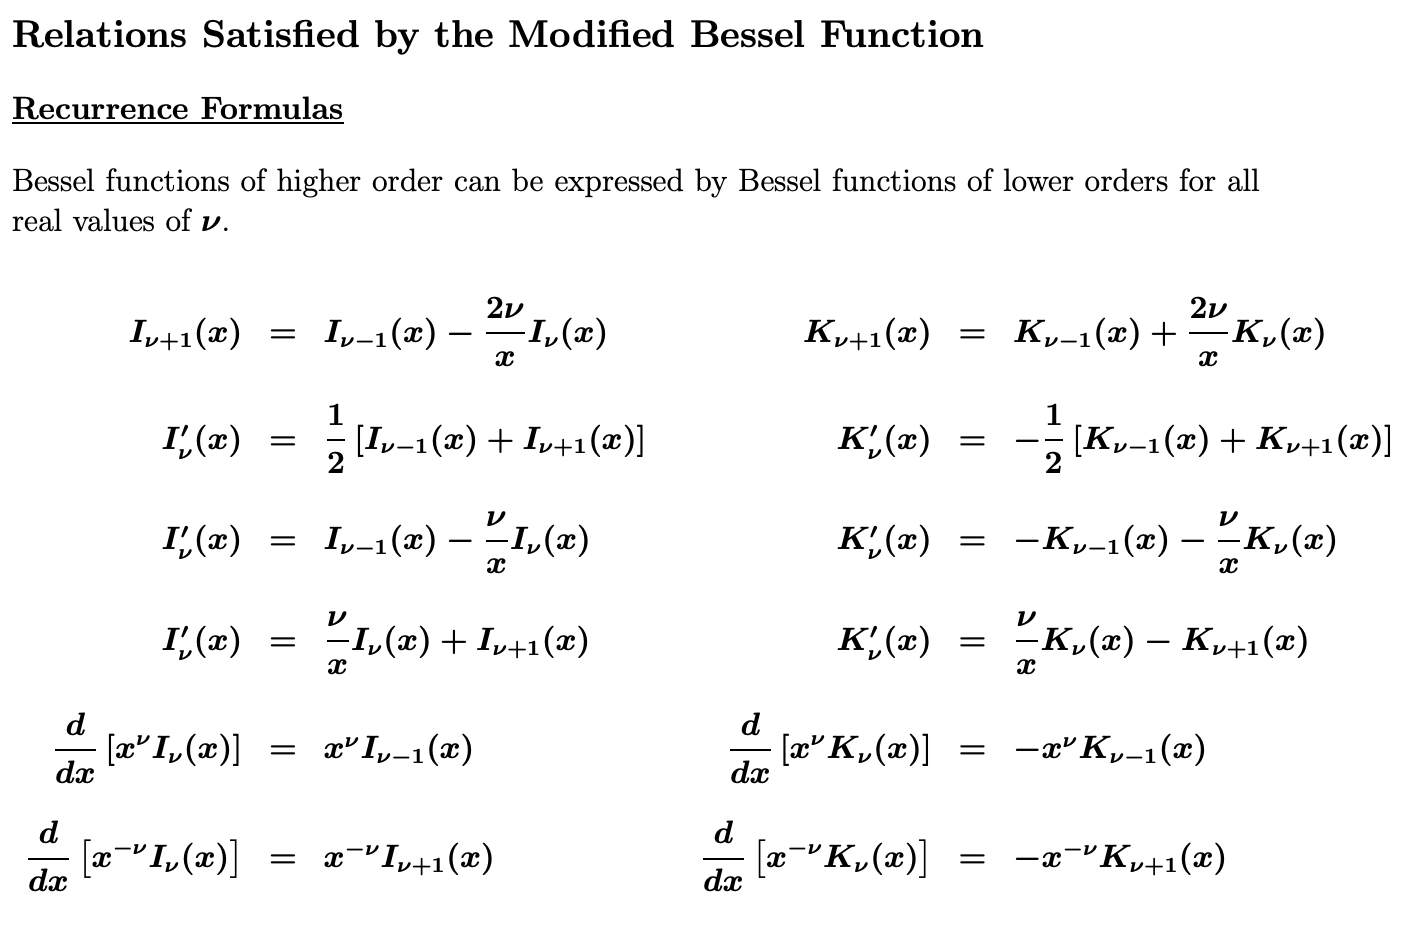

## Definitions .....................................................................

### 1. Bessel Equation

The second order differential equation given as

x^2 y'' + x y' + (x^2 - v^2)y=0

$x^2
d^2 y
dx^2
+x
dy
dx
−(x^2 +ν^2 )y=0$
```
$x^2 d^2 ydx^2 +x dy dx +(x^2 −ν^2 )y=0$
```
is known as Bessel’s equation. Where the solution to Bessel’s equation yields Bessel functions
of the first and second kind as follows:

$y=AJν(x)+BYν(x)$
```
y=AJν(x)+BYν(x)
```
whereAandBare arbitrary constants. While Bessel functions are often presented in text
books and tables in the form of integer order, i.e. ν=0, 1 , 2 ,...,infact they are defined
for all real values of−∞<ν<∞.

### 2. Bessel Functions

```
a) First Kind: Jν(x)in the solution to Bessel’s equation is referred to as a Bessel
function of the first kind.
b) Second Kind: Yν(x) in the solution to Bessel’s equation is referred to as a
Bessel function of the second kind or sometimes the Weber function or the
Neumann function.
b) Third Kind: The Hankel function or Bessel function of the third kind can be
written as
```
```
Hν(1)(x)=Jν(x)+iYν(x) x> 0
Hν(2)(x)=Jν(x)−iYν(x) x> 0
```
```
Because of the linear independence of the Bessel function of the first and second
kind, the Hankel functions provide an alternative pair of solutions to the Bessel
differential equation.
```

### 3. Modified Bessel Equation

By lettingx= ix(wherei=

#### √

− 1 )inthe Bessel equation we can obtain the modified
Bessel equation of orderν,given as

```
x^2
d^2 y
dx^2
+x
dy
dx
−(x^2 +ν^2 )y=
```
The solution to the modified Bessel equation yields modified Bessel functions of the first and
second kind as follows:

```
y=CIν(x)+DKν(x) x> 0
```
### 4. Modified Bessel Functions

```
a) First Kind: Iν(x)in the solution to the modified Bessel’s equation is referred
to as a modified Bessel function of the first kind.
b) Second Kind: Kν(x)in the solution to the modified Bessel’s equation is re-
ferred to as a modified Bessel function of the second kind or sometimes the
Weberfunction or the Neumann function.
```

# Hyperbolic Trig Definitions
Source: https://en.wikipedia.org/wiki/Hyperbolic_functions#Exponential_definitions on 2021_07_13

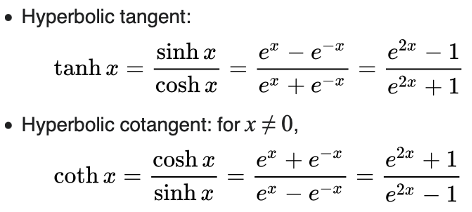